In [1]:
from IPython.display import display, HTML

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from Scripts.utils.bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from Scripts.utils.preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from Scripts.utils.bert_embeddings import load_bert_embeddings
from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from Scripts.utils.general_utils import timer
import Scripts.utils.config as CONFIG
from attm_utils import load_pickle
from attm_dataloaders import CPDatasetMT, CPDatasetST
from attm_data_utils import get_train_test_ssda
from attm_metrics import calculate_scores, calculate_scores_single, get_accuracy_from_logits,print_res
from attm_model_utils import evaluate_mt, evaluate_st
from attm_single_task import AttentionST
from attm_multi_task import AttentionMT
from attm_run_ssda import run_ssda_cp_mt, run_ssda_cp_st, run_ssda_MT, run_ssda_ST
import  gc
import time
import pickle
import dill

....... Initializing Settings ..... 
Random_Seed Chosen : 15112
Learning Rates Used : 
[0.001, 0.0001]


In [5]:
from attm_utils import batch_text_gen, batch_gen_pred, tokenize_4bert_batch

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

In [7]:
np.random.seed(CONFIG.RANDOM_SEED)

In [8]:
torch.manual_seed(2401990)

In [9]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [10]:
# Datagen from clean_df

In [11]:
def plot_epoch_loss_multi(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(25,10))
    
    axes = ax.ravel()
    
    ax[0].plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",alpha=0.4,label="Total Loss")
    ax[0].plot(range(len(epoch_losses["word_loss"])),epoch_losses["word_loss"],c="blue",alpha=0.3,label="Word Loss")
    ax[0].plot(range(len(epoch_losses["rs_loss"])),epoch_losses["rs_loss"],c="red",label="RS Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Training Loss")
    ax[0].set_title("Training Loss for ATMT")
    
    ax[1].plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="green",alpha=0.4,label="Total Loss")
    ax[1].plot(range(len(epoch_losses["word_loss_val"])),epoch_losses["word_loss_val"],c="blue",alpha=0.3,label="Word Loss")
    ax[1].plot(range(len(epoch_losses["rs_loss_val"])),epoch_losses["rs_loss_val"],c="red",label="RS Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Validation Loss")
    ax[1].set_title("Validation Loss for ATMT")
    plt.legend()
    plt.show()

In [12]:
def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",label="Training Loss")
    ax.plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="red",label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    plt.legend()
    plt.show()

In [13]:
@timer
def select_cps(cps,cluster_2_doc_map,df,keywords=["democrats", "media","socialist","donald", "republicans", "progressive"]):
    """
    calculate normalized dfs for each cluster pair keywords (sum them for indiv clusters) then rank and then find avg rank
    
    cluster, keyword = doc_freq
    """
    # Get Document frequency for keywords
    clusters = list(set(np.array([[cp[0],cp[1]] for cp in cps]).flatten().tolist()))
    df["processed_all"] = df["processed_title"] + " "+ df['processed_text']
    print("Num clusters : %s" %str(len(clusters)))
    print(clusters)
    keyword_clus_doc_freq = defaultdict(lambda :defaultdict(int))
    for cluster in clusters:
        c_docs = cluster_2_doc_map[cluster]
        for c_doc in c_docs:
            for keyword in keywords:
                if keyword in df["processed_all"].iloc[c_doc]:
                    keyword_clus_doc_freq[cluster][keyword]+=1
        
    # Now lets normalize the scores
    for cluster in clusters:
        for keyword in keywords:
            c_docs = cluster_2_doc_map[cluster]
            if keyword_clus_doc_freq[cluster][keyword] > 0:
                keyword_clus_doc_freq[cluster][keyword] /= len(c_docs)
    
    print(keyword_clus_doc_freq)
    
    # Now lets rank cps
    keyword_clusp_ranks = []
    for cp in cps:
        c1_normdf_total = 0
        c2_normdf_total = 0
        for keyword in keywords:
            c1_normdf_total += keyword_clus_doc_freq[cp[0]][keyword]
            c2_normdf_total += keyword_clus_doc_freq[cp[1]][keyword]
        
        total_cp_norm_df = c1_normdf_total + c2_normdf_total
        keyword_clusp_ranks.append((cp,total_cp_norm_df))
    
    return sorted(keyword_clusp_ranks,key=lambda x: x[1],reverse=True)
        
            

In [14]:
def load_results(cluster_pair,multi=True):
    """
    """
    scores_test =  None
    losses_train = None
    scores_train = None
    
    scores_test_att =  None
    losses_train_att = None
    scores_train_att = None
    
    scores_test_multi =  None
    losses_train_multi = None
    scores_train_multi = None
    
    with open("att_pickle_objs_results/%s_metrics_test_single.pickle"%str(cluster_pair),"rb") as mt:
        scores_test = dill.load(mt)
    with open("att_pickle_objs_results/%s_loss_single.pickle"%str(cluster_pair),"rb") as mt:
        losses_train = dill.load(mt)
    with open("att_pickle_objs_results/%s_metrics_train_single.pickle"%str(cluster_pair),"rb") as mt:
        scores_train = dill.load(mt)
    
    
    with open("att_pickle_objs_results/%s_metrics_test_single_att.pickle"%str(cluster_pair),"rb") as mt:
        scores_test_att = dill.load(mt)
    with open("att_pickle_objs_results/%s_loss_single_att.pickle"%str(cluster_pair),"rb") as mt:
        losses_train_att = dill.load(mt)
    with open("att_pickle_objs_results/%s_metrics_train_single_att.pickle"%str(cluster_pair),"rb") as mt:
        scores_train_att = dill.load(mt)
    
    if multi :
        with open("att_pickle_objs_results/%s_metrics_test_multi_att.pickle"%str(cluster_pair),"rb") as mt:
            scores_test_multi = dill.load(mt)
        with open("att_pickle_objs_results/%s_loss_multi_att.pickle"%str(cluster_pair),"rb") as mt:
            losses_train_multi = dill.load(mt)
        with open("att_pickle_objs_results/%s_metrics_train_multi_att.pickle"%str(cluster_pair),"rb") as mt:
            scores_train_multi = dill.load(mt)  
    
    return scores_test, losses_train, scores_train, scores_test_att, losses_train_att, scores_train_att, scores_test_multi, losses_train_multi, scores_train_multi

In [15]:
cps = load_pickle('att_pickle_objs_input/top100.pickle')

In [16]:
data = load_pickle("att_pickle_objs_input/clean_df.pickle")

In [17]:
data.shape

(95120, 9)

In [18]:
data.columns

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_'],
      dtype='object')

In [19]:
doc_2_cluster_map = load_pickle('att_pickle_objs_input/d2c_map.pickle')

In [20]:
# type(cps[0][0])

In [21]:
sorted_cps = select_cps(cps,doc_2_cluster_map,data,keywords=["democrats", "media","socialist","donald", "republicans", "progressive"])

Num clusters : 40
[0, 1, 4, 7, 9, 14, 15, 16, 20, 22, 26, 28, 30, 35, 36, 38, 39, 43, 44, 46, 52, 56, 57, 58, 59, 60, 61, 62, 63, 71, 74, 82, 85, 86, 89, 91, 93, 97, 98, 99]
defaultdict(<function select_cps.<locals>.<lambda> at 0x7f69dd311e50>, {0: defaultdict(<class 'int'>, {'democrats': 0.5737142857142857, 'republicans': 0.3417142857142857, 'media': 0.23314285714285715, 'socialist': 0.029714285714285714, 'donald': 0.312, 'progressive': 0.048}), 1: defaultdict(<class 'int'>, {'democrats': 0.26877761413843887, 'media': 0.36818851251840945, 'donald': 0.31516936671575846, 'republicans': 0.13843888070692195, 'progressive': 0.061855670103092786, 'socialist': 0.029455081001472753}), 4: defaultdict(<class 'int'>, {'donald': 0.25183823529411764, 'republicans': 0.09099264705882353, 'democrats': 0.17738970588235295, 'media': 0.32536764705882354, 'socialist': 0.012867647058823529, 'progressive': 0.03768382352941176}), 7: defaultdict(<class 'int'>, {'democrats': 0.44642857142857145, 'media': 0.24

In [42]:
data.columns

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'processed_all'],
      dtype='object')

In [64]:
sorted_cps

[((14, 44), 2.864814723197942),
 ((0, 30), 2.8013562537048013),
 ((22, 58), 2.787720648008361),
 ((22, 36), 2.7679559062975994),
 ((1, 22), 2.666853479614474),
 ((1, 86), 2.6176551748647188),
 ((44, 74), 2.616952076942841),
 ((36, 58), 2.585739845445201),
 ((14, 43), 2.57426145468885),
 ((30, 74), 2.530989815689094),
 ((71, 93), 2.502433860407608),
 ((71, 74), 2.480766831399441),
 ((15, 93), 2.4746861516683425),
 ((30, 63), 2.467166102559019),
 ((15, 74), 2.4530191226601756),
 ((60, 63), 2.411508250239005),
 ((43, 44), 2.4075123328365766),
 ((15, 71), 2.3979474015196027),
 ((57, 93), 2.3824489299903764),
 ((57, 74), 2.36078190098221),
 ((82, 93), 2.340606713441439),
 ((43, 74), 2.3263988084337495),
 ((30, 82), 2.3140909475823523),
 ((44, 52), 2.3035043453882813),
 ((26, 93), 2.291744578659469),
 ((15, 57), 2.277962471102372),
 ((26, 74), 2.270077549651302),
 ((26, 30), 2.265228812800382),
 ((43, 63), 2.2625750953036743),
 ((60, 82), 2.2584330952623386),
 ((63, 82), 2.255115971303197),


In [73]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001,0.001,0.01],
                                                            epochs=5,
                                                            batch_size=4,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (975, 10)
1 : 423
0 : 552

Sample size from C2 in Train : (97, 10)
1 : 50
0 : 47

Train Size : (1072, 10)
1 : 473
0 : 599

Sample Size from C1 in Test : (419, 10)
1 : 174
0 : 245

Sample Size from C2 in Test : (419, 10)
1 : 215
0 : 204

Test Size : (838, 10)
1 : 389
0 : 449


KeyboardInterrupt: 

In [48]:
metrics_train.keys()

dict_keys([0.01, 0.1])

In [49]:
losses_train.keys()

dict_keys([0.01, 0.1])

In [74]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001,0.001,0.01],
                                                            word_pred_loss_weights=[0.1,0.3,0.8,1.0],
                                                            epochs=5,
                                                            batch_size=4,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5366, 5)
1 : 2354
0 : 3012

Sample size from C2 in Train : (536, 5)
1 : 264
0 : 272

Train Size : (5902, 5)
1 : 2618
0 : 3284

Sample Size from C1 in Test : (2300, 5)
1 : 983
0 : 1317

Sample Size from C2 in Test : (2300, 5)
1 : 1071
0 : 1229

Test Size : (4600, 5)
1 : 2054
0 : 2546
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


KeyboardInterrupt: 

In [44]:
train_scores = None
with open("att_pickle_objs_results/(0, 30)_metrics_train_single.pickle","rb") as handle:
    train_scores = dill.load(handle)

In [45]:
train_scores.keys()

dict_keys([1e-05, 0.0001, 0.001, 0.01])

In [46]:
train_scores[0.01].keys()

dict_keys(['overall', 'cluster1', 'cluster2'])

In [47]:
train_scores[0.01]["overall"]

defaultdict(<function attm_metrics.<lambda>()>,
            {'class_scores': defaultdict(float,
                         {'f1': 0.7741935483870968,
                          'precision': 0.6540284360189573,
                          'recall': 0.9484536082474226,
                          'accuracy': 0.7831273276839208,
                          'roc_auc': 0.7607726597325408})})

In [48]:
train_loss = None
with open("att_pickle_objs_results/(0, 30)_loss_single.pickle","rb") as handle:
    train_loss = dill.load(handle)

In [49]:
train_loss.keys()

dict_keys([1e-05, 0.0001, 0.001, 0.01])

422.5

In [56]:


N = 5
max_val, min_val = 0.01, 0.00000001
range_size = (max_val - min_val)  # 2
np.random.rand(N) * range_size + min_val

array([3.41245396e-03, 8.08114567e-03, 3.30546702e-03, 8.55788631e-03,
       8.65761124e-05])

In [60]:
def random_search_lr(n,max_lr=0.001,min_lr=0.0000001):
    """
    """
    range_size = (max_lr - min_lr)  # 2
    lrs = (np.random.rand(n) * range_size + min_lr).tolist()
    return lrs

In [61]:
lr = random_search_lr(10)

In [62]:
lr

[0.0007231048406679875,
 0.00039861319973326647,
 0.00015914792150126708,
 0.0006502884253383948,
 0.0006411521123407676,
 0.00023396399376241435,
 0.00012714200346605468,
 0.0003312195494200387,
 0.00031714525589067124,
 0.000781623522986814]

In [65]:
scores_test =  None
losses_train = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_single.pickle","rb") as mt:
    scores_test = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_single.pickle","rb") as mt:
    losses_train = dill.load(mt)

In [66]:
print_res(scores_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.00100,overall,class_scores,0.449468,0.465565,0.434447,0.505967,0.501188
1,0.00100,cluster1,class_scores,0.558282,0.598684,0.522989,0.656325,0.637004
2,0.00100,cluster2,class_scores,0.366197,0.369668,0.362791,0.355609,0.355415
3,0.00010,overall,class_scores,0.200758,0.381295,0.136247,0.496420,0.472355
4,0.00010,cluster1,class_scores,0.236842,0.500000,0.155172,0.584726,0.522484
5,0.00010,cluster2,class_scores,0.173333,0.305882,0.120930,0.408115,0.415857
6,0.00001,overall,class_scores,0.043373,0.346154,0.023136,0.526253,0.492637
7,0.00001,cluster1,class_scores,0.052910,0.333333,0.028736,0.572792,0.493960
8,0.00001,cluster2,class_scores,0.035398,0.363636,0.018605,0.479714,0.492145


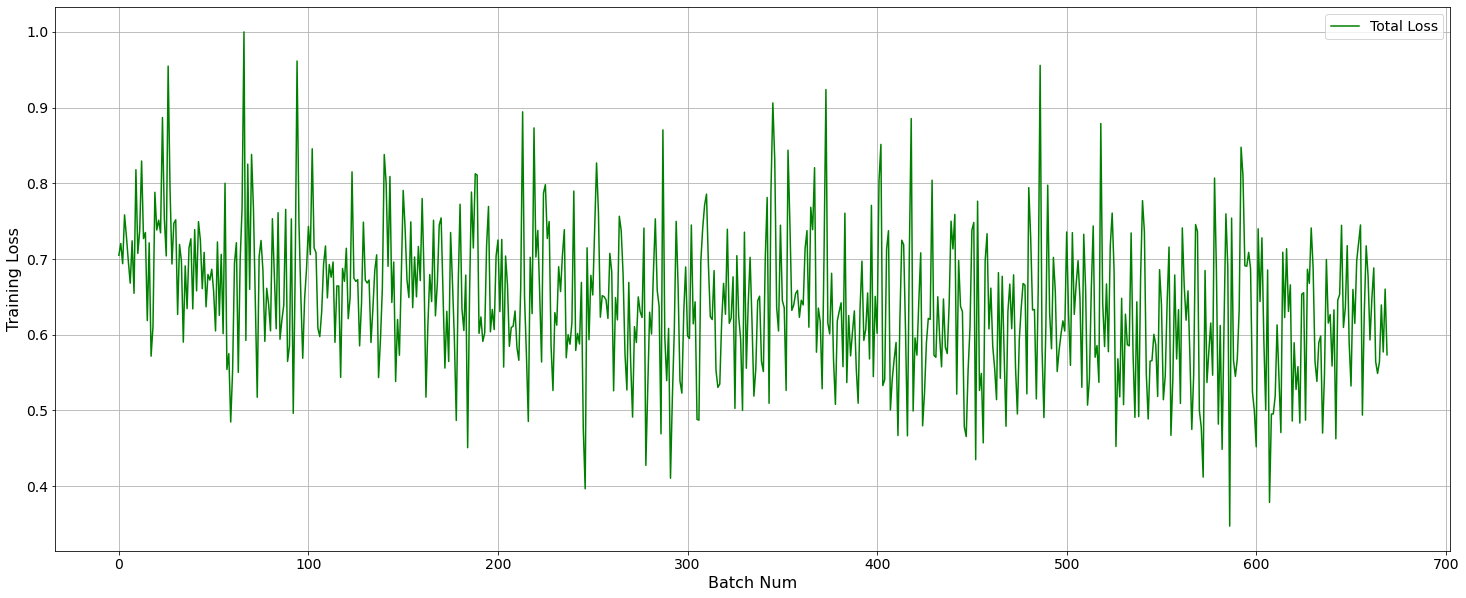

In [75]:
plot_epoch_loss(losses_train[0.001])

In [68]:
scores_test_w_att =  None
losses_train_w_att = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_single_att.pickle","rb") as mt:
    scores_test_w_att = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_single_att.pickle","rb") as mt:
    losses_train_w_att = dill.load(mt)

In [69]:
print_res(scores_test_w_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.00100,overall,class_scores,0.380518,0.466418,0.321337,0.514320,0.501426
1,0.00100,cluster1,class_scores,0.594406,0.758929,0.488506,0.723150,0.689151
2,0.00100,cluster2,class_scores,0.215633,0.256410,0.186047,0.305489,0.308710
3,0.00010,overall,class_scores,0.188235,0.396694,0.123393,0.505967,0.480405
4,0.00010,cluster1,class_scores,0.207207,0.479167,0.132184,0.579952,0.515072
5,0.00010,cluster2,class_scores,0.173611,0.342466,0.116279,0.431981,0.440492
6,0.00001,overall,class_scores,0.000000,0.000000,0.000000,0.535800,0.500000
7,0.00001,cluster1,class_scores,0.000000,0.000000,0.000000,0.584726,0.500000
8,0.00001,cluster2,class_scores,0.000000,0.000000,0.000000,0.486874,0.500000


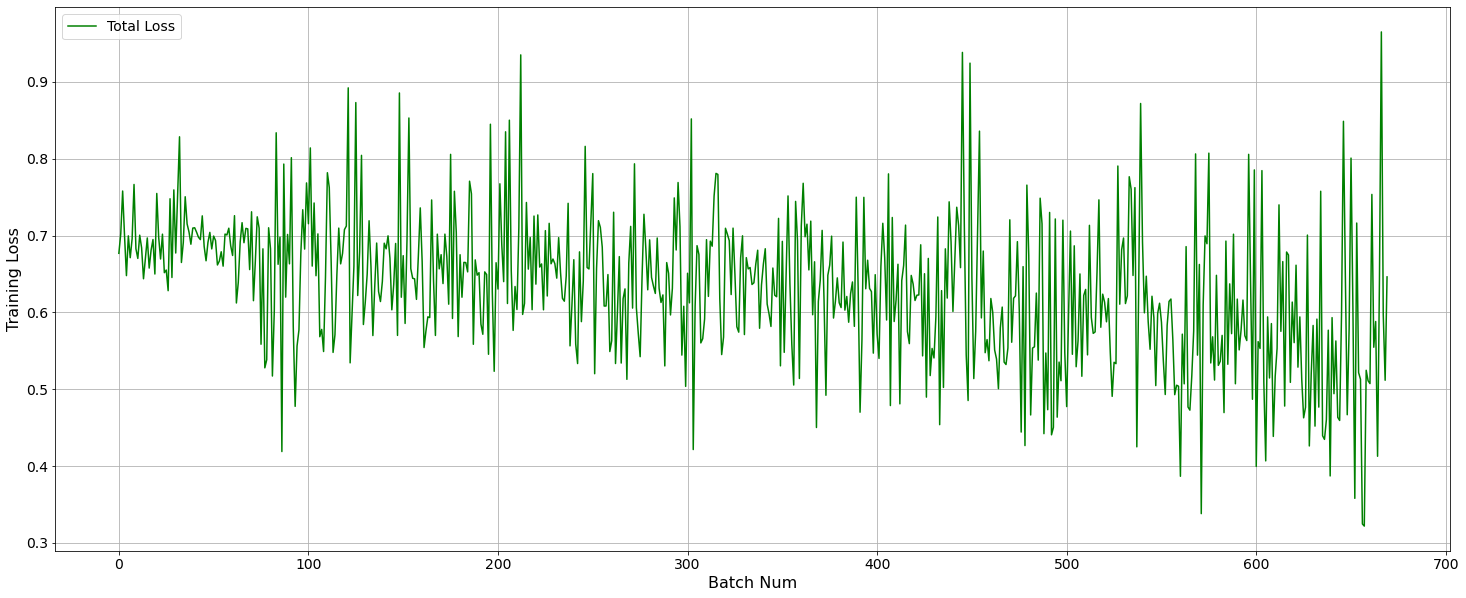

In [70]:
plot_epoch_loss(losses_train_w_att[0.001])

In [71]:
scores_test_multi_att = None
losees_train_multi_att = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_multi_att.pickle","rb") as mt:
    scores_test_multi_att = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_multi_att.pickle","rb") as mt:
    losees_train_multi_att = dill.load(mt)

In [72]:
print_res(scores_test_multi_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.599106,0.453952,0.880721,0.473696,0.513023
1,"(0.001, 0.1)",overall,word_scores,0.559884,0.450832,0.738528,0.471957,0.494065
2,"(0.001, 0.1)",cluster1,class_scores,0.621300,0.466769,0.928789,0.516087,0.568419
3,"(0.001, 0.1)",cluster1,word_scores,0.556126,0.449852,0.728146,0.473913,0.495924
4,"(0.001, 0.1)",cluster2,class_scores,0.578065,0.441597,0.836601,0.431304,0.457357
5,"(0.001, 0.1)",cluster2,word_scores,0.563552,0.451780,0.748811,0.470000,0.492099
6,"(0.001, 0.4)",overall,class_scores,0.322156,0.495951,0.238559,0.551739,0.521479
7,"(0.001, 0.4)",overall,word_scores,0.562995,0.451501,0.747610,0.472174,0.495017
8,"(0.001, 0.4)",cluster1,class_scores,0.448370,0.674847,0.335707,0.646957,0.607489
9,"(0.001, 0.4)",cluster1,word_scores,0.559796,0.450292,0.739673,0.473478,0.496525


In [57]:
losees_train_multi_att.keys()

dict_keys([(0.001, 0.1), (0.001, 0.4), (0.001, 0.8), (0.0001, 0.1), (0.0001, 0.4), (0.0001, 0.8), (1e-05, 0.1), (1e-05, 0.4), (1e-05, 0.8)])

In [58]:
losees_train_multi_att[(0.001, 0.8)].keys()

dict_keys(['rs_loss', 'word_loss', 'total_loss'])

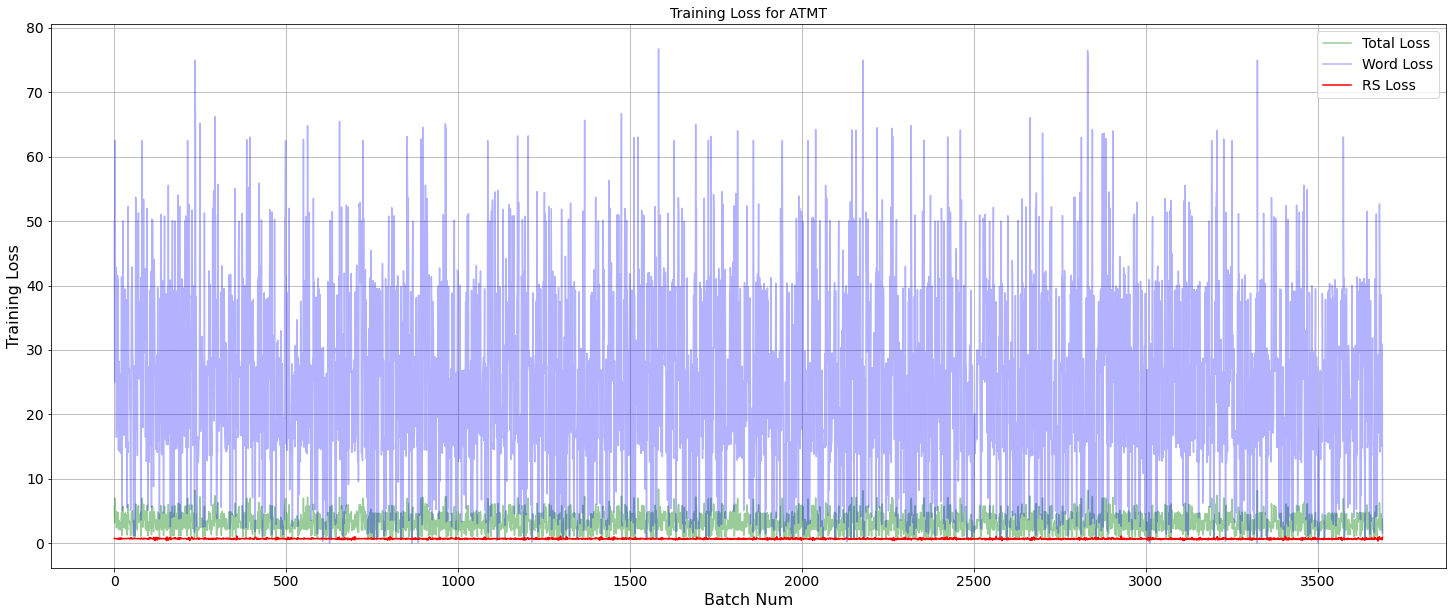

In [76]:
plot_epoch_loss_multi(losees_train_multi_att[(0.001, 0.1)])

# Overfit test

We want to check if the model is overfitting on a small data size to make sure the loss curve can be smooth , if not we need to add more layers as the model is too simple to capture patterns.

### Using Batch Size of 1

In [97]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=10,
                                                            batch_size=1,
                                                            single_task=True,
                                                            with_attention=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Epoch : 0 | Batch : 100 | Total Loss : 0.4746896028518677 
True Rec Labels : tensor([1.], device='cuda:1')
Batch Class Predictions : tensor([0.6221], device='cuda:1', grad_fn=<SigmoidBackward>)
[1.]
Batch Accuracy class : 1.0
Epoch : 0 | Batch : 200 | Total Loss : 0.7725903987884521 
True Rec Labels : tensor([1.], device='cuda:1')
Batch Class Predictions : tensor([0.4618], device='cuda:1', grad_fn=<SigmoidBackward>)
[0.]
Batch Accuracy class : 0.0
Epoch : 0 | Batch : 300 | Tot

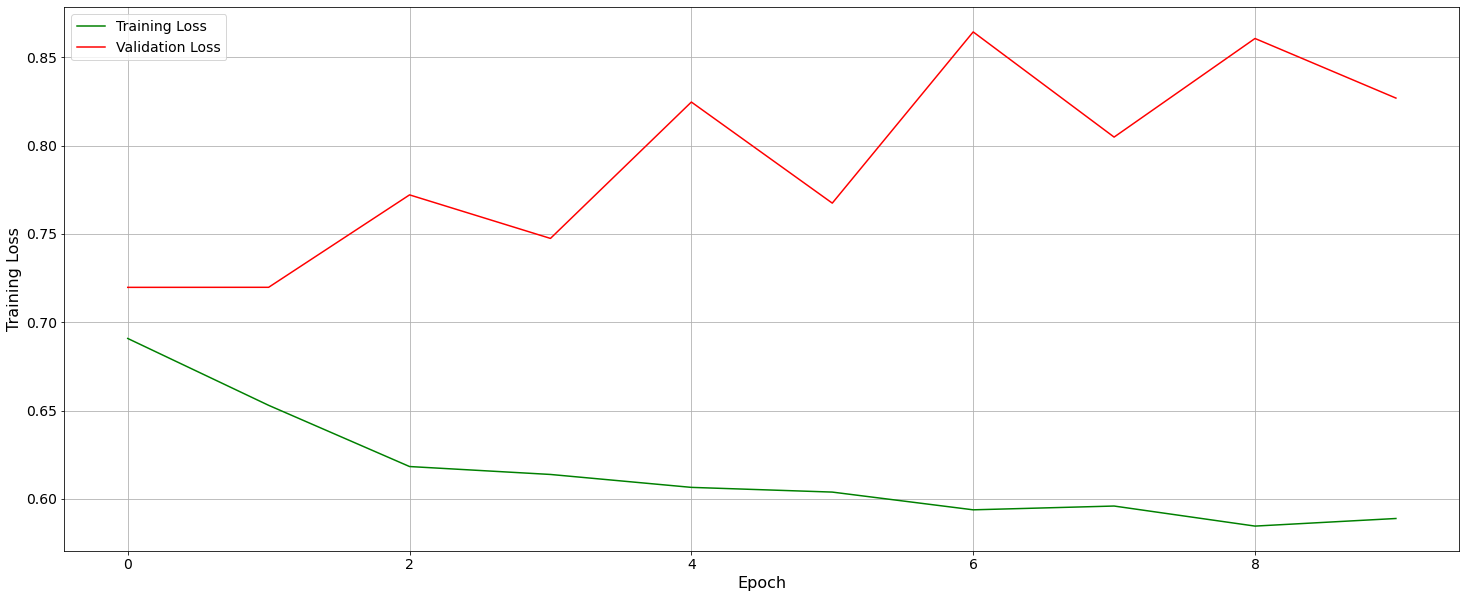

In [98]:
plot_epoch_loss(losses_train[0.001])

In [99]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.286472,0.473684,0.205323,0.517921,0.500967
1,0.001,cluster1,class_scores,0.405063,0.744186,0.278261,0.663082,0.605594
2,0.001,cluster2,class_scores,0.200913,0.309859,0.148649,0.372760,0.387301


In [100]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.485926,0.845361,0.340956,0.685403,0.646362
1,0.001,cluster1,class_scores,0.500835,0.877193,0.350467,0.701894,0.656973
2,0.001,cluster2,class_scores,0.368421,0.608696,0.264151,0.520000,0.536331


In [101]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=10,
                                                            batch_size=1,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Epoch : 0 | Batch : 100 | Total Loss : 0.7029039263725281 
True Rec Labels : tensor([1.], device='cuda:1')
Batch Class Predictions : tensor([0.4951], device='cuda:1', grad_fn=<SigmoidBackward>)
[0.]
Batch Accuracy class : 0.0
Epoch : 0 | Batch : 200 | Total Loss : 0.5730432868003845 
True Rec Labels : tensor([0.], device='cuda:1')
Batch Class Predictions : tensor([0.4362], device='cuda:1', grad_fn=<SigmoidBackward>)
[0.]
Batch Accuracy class : 1.0
Epoch : 0 | Batch : 300 | Tot

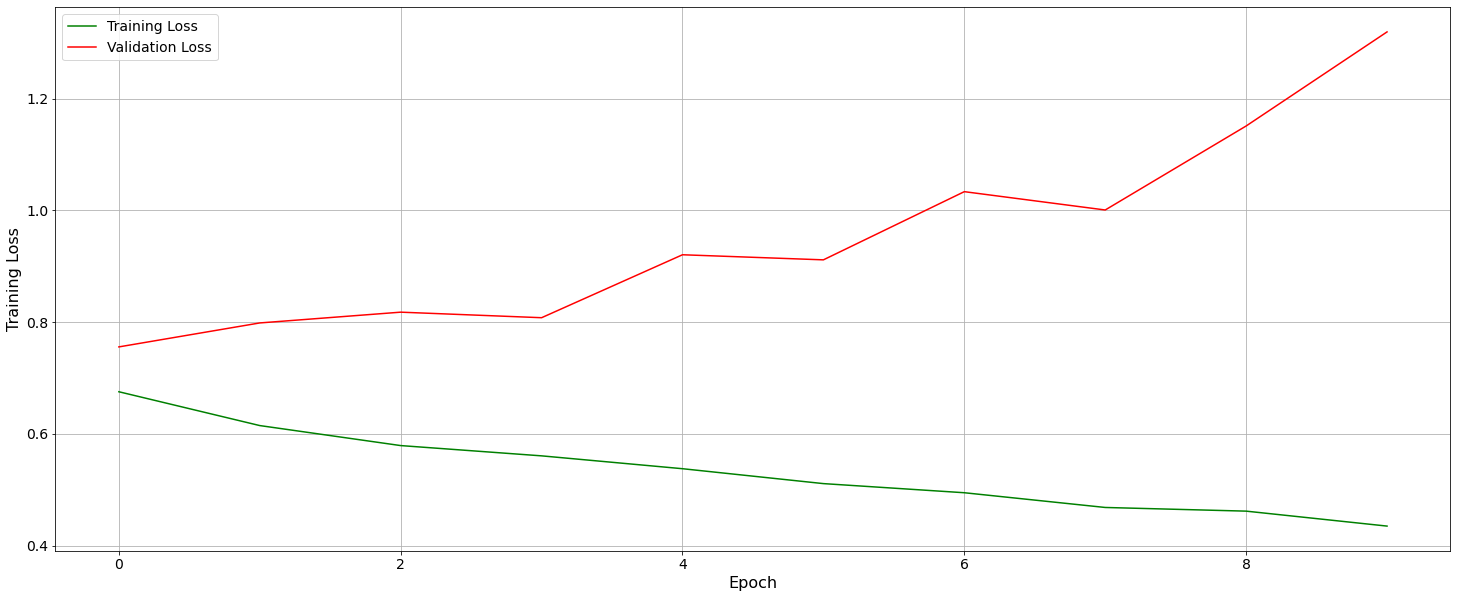

In [102]:
plot_epoch_loss(losses_train[0.001])

In [103]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.291005,0.478261,0.209125,0.519713,0.502868
1,0.001,cluster1,class_scores,0.432099,0.744681,0.304348,0.670251,0.615589
2,0.001,cluster2,class_scores,0.185185,0.294118,0.135135,0.369176,0.384361


In [104]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.572263,0.960784,0.407484,0.734361,0.697311
1,0.001,cluster1,class_scores,0.587276,0.972973,0.420561,0.747757,0.705933
2,0.001,cluster2,class_scores,0.444444,0.842105,0.301887,0.600000,0.619029


### Entire Dataset

#### Without Attention Single Task Network

In [57]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001],
                                                            epochs=20,
                                                            batch_size=16,
                                                            single_task=True,
                                                            with_attention=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Avg Batch Loss Train : 0.689199673956719
Avg Batch Loss Val : 0.6821047408240182
Avg Batch Loss Train : 0.6825894782508629
Avg Batch Loss Val : 0.682205502476011
Avg Batch Loss Train : 0.6752168752145076
Avg Batch Loss Val : 0.6805636925356728
Avg Batch Loss Train : 0.6713380036146744
Avg Batch Loss Val : 0.6802157121045249
Avg Batch Loss Train : 0.6732047079265981
Avg Batch Loss Val : 0.680612346955708
Avg Batch Loss Train : 0.6690351608870686
Avg Batch Loss Val : 0.681776889

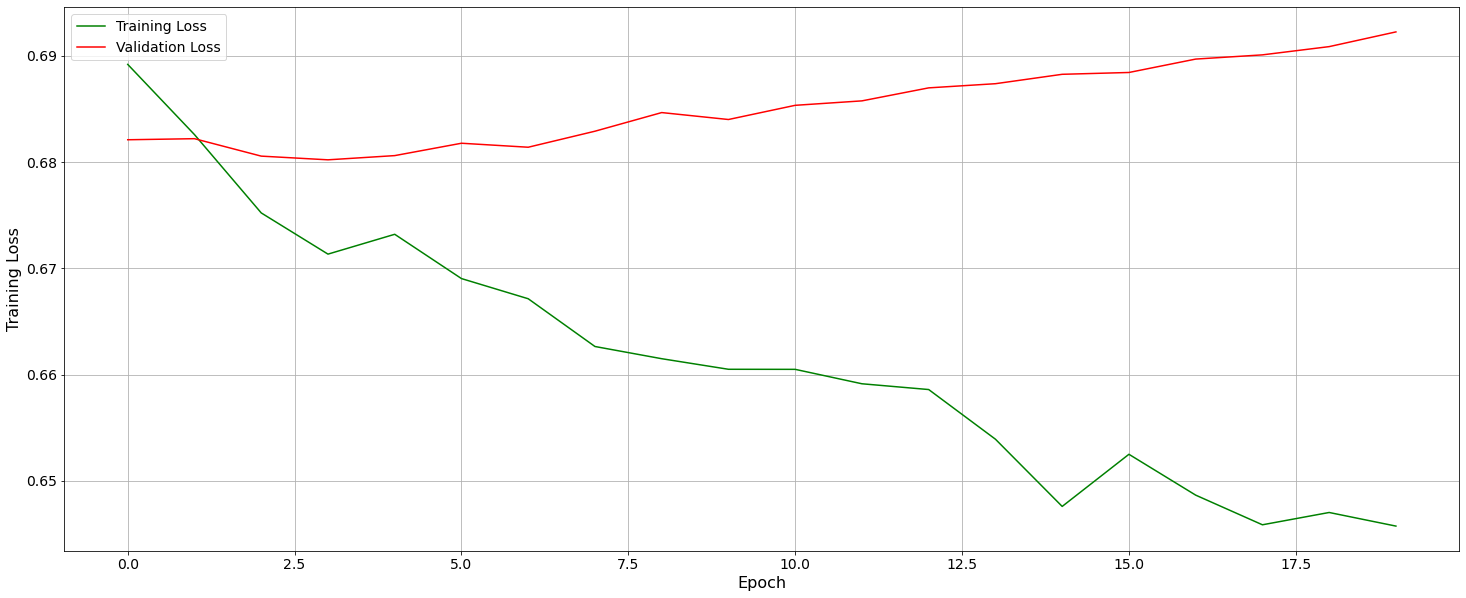

In [58]:
plot_epoch_loss(losses_train[0.0001])

In [59]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.217270,0.406250,0.148289,0.496416,0.477534
1,0.0001,cluster1,class_scores,0.320513,0.609756,0.217391,0.620072,0.559915
2,0.0001,cluster2,class_scores,0.137931,0.254545,0.094595,0.372760,0.390809


In [60]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.347287,0.682927,0.232848,0.618314,0.574623
1,0.0001,cluster1,class_scores,0.356021,0.703448,0.238318,0.632104,0.581768
2,0.0001,cluster2,class_scores,0.277778,0.526316,0.188679,0.480000,0.498595


#### With Attention Single Task Network

In [61]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001],
                                                            epochs=20,
                                                            batch_size=4,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Epoch : 0 | Batch : 100 | Total Loss : 0.7003666758537292 
True Rec Labels : tensor([[0.],
        [0.],
        [1.],
        [1.]], device='cuda:1')
Batch Class Predictions : tensor([0.4537, 0.4699, 0.4661, 0.4499], device='cuda:1',
       grad_fn=<SqueezeBackward0>)
[0. 0. 0. 0.]
Batch Accuracy class : 0.5
Epoch : 0 | Batch : 200 | Total Loss : 0.7207890152931213 
True Rec Labels : tensor([[1.],
        [1.],
        [1.],
        [0.]], device='cuda:1')
Batch Class Predict

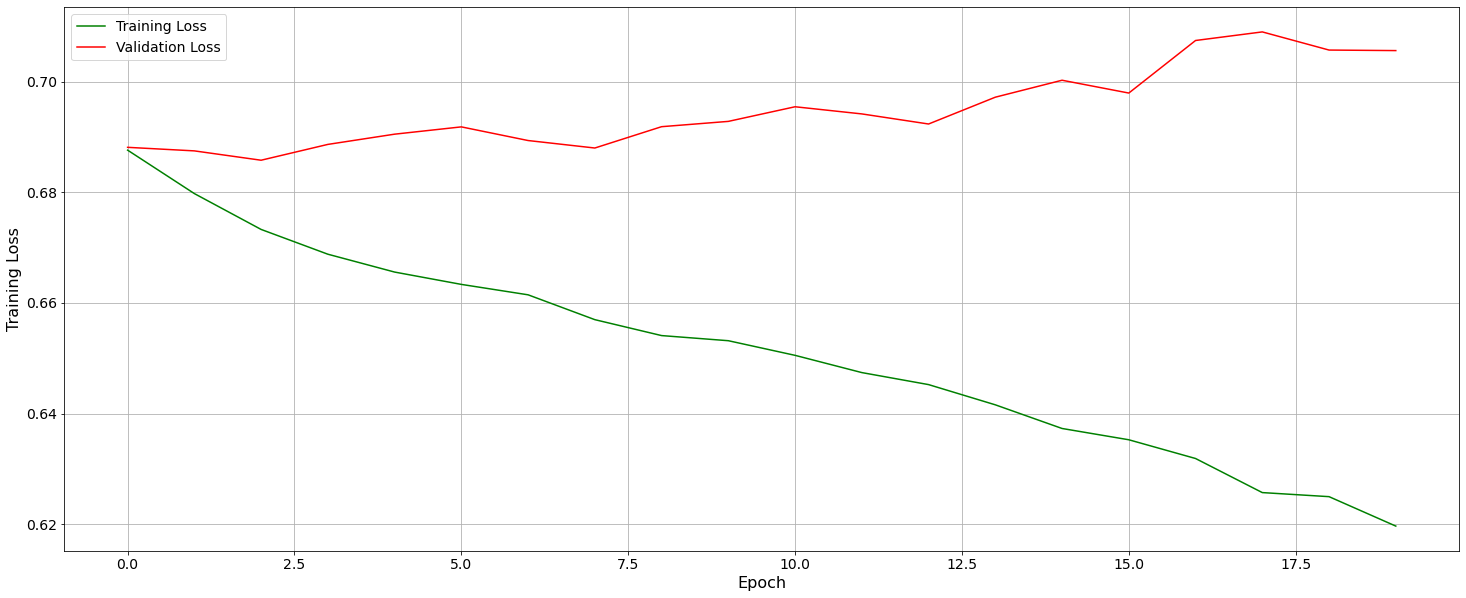

In [62]:
plot_epoch_loss(losses_train[0.0001])

In [63]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.238482,0.415094,0.167300,0.496416,0.478565
1,0.0001,cluster1,class_scores,0.368421,0.756757,0.243478,0.655914,0.594300
2,0.0001,cluster2,class_scores,0.147465,0.231884,0.108108,0.336918,0.351764


In [64]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.424886,0.786517,0.291060,0.656392,0.614984
1,0.0001,cluster1,class_scores,0.441379,0.842105,0.299065,0.676969,0.628663
2,0.0001,cluster2,class_scores,0.303797,0.461538,0.226415,0.450000,0.464271


### Adding Extra Linear Layer before Output Layer

#### Without Attention Single Task Network

In [67]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001],
                                                            epochs=20,
                                                            batch_size=16,
                                                            single_task=True,
                                                            with_attention=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Avg Batch Loss Train : 0.6813274172769077
Avg Batch Loss Val : 0.6845281251839229
Avg Batch Loss Train : 0.6712186621583026
Avg Batch Loss Val : 0.6859039621693748
Avg Batch Loss Train : 0.6642415238463361
Avg Batch Loss Val : 0.6889466260160718
Avg Batch Loss Train : 0.6583246942879497
Avg Batch Loss Val : 0.6941535728318351
Avg Batch Loss Train : 0.6544555192408354
Avg Batch Loss Val : 0.693181791475841
Avg Batch Loss Train : 0.648184029088504
Avg Batch Loss Val : 0.69523751

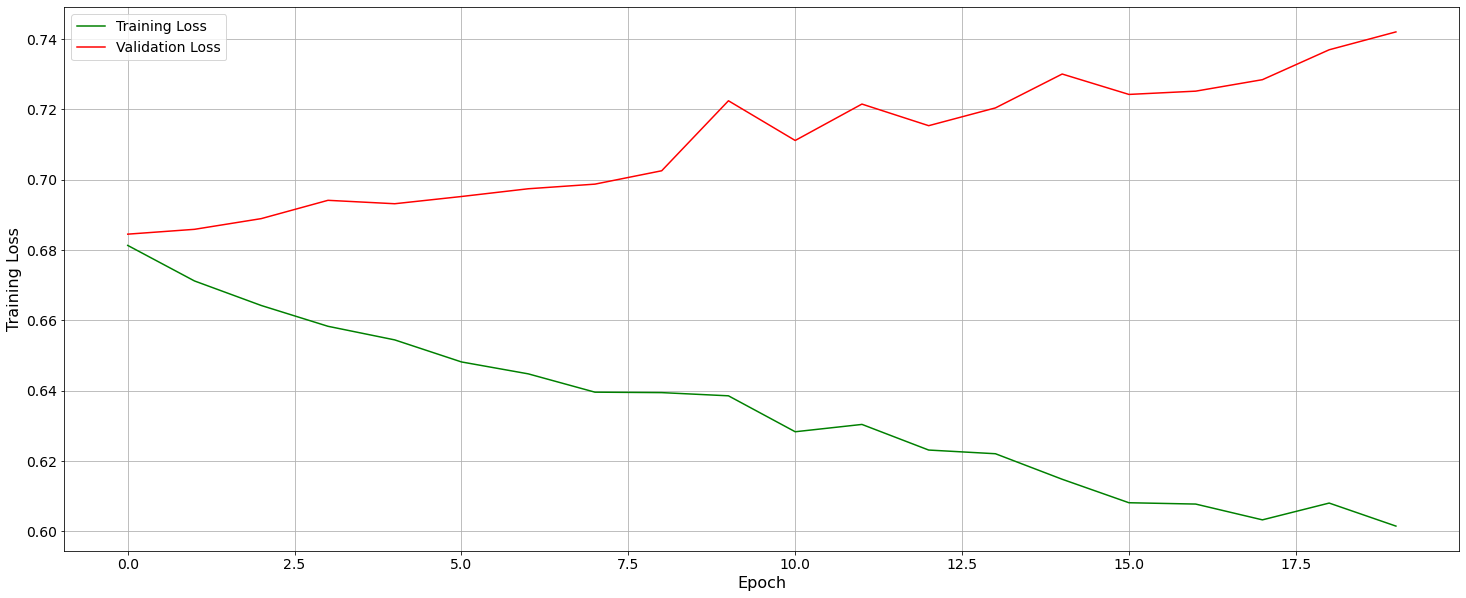

In [68]:
plot_epoch_loss(losses_train[0.0001])

In [69]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.249307,0.459184,0.171103,0.514337,0.495721
1,0.0001,cluster1,class_scores,0.344371,0.722222,0.226087,0.645161,0.582556
2,0.0001,cluster2,class_scores,0.180952,0.306452,0.128378,0.383513,0.400067


In [70]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.415663,0.754098,0.286902,0.648232,0.607278
1,0.0001,cluster1,class_scores,0.434635,0.795031,0.299065,0.667996,0.620837
2,0.0001,cluster2,class_scores,0.266667,0.454545,0.188679,0.450000,0.466680


#### With Attention Single Task Network

In [71]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001],
                                                            epochs=20,
                                                            batch_size=4,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Epoch : 0 | Batch : 100 | Total Loss : 0.6978853940963745 
True Rec Labels : tensor([[0.],
        [0.],
        [1.],
        [0.]], device='cuda:1')
Batch Class Predictions : tensor([0.4986, 0.4924, 0.4740, 0.4917], device='cuda:1',
       grad_fn=<SqueezeBackward0>)
[0. 0. 0. 0.]
Batch Accuracy class : 0.75
Epoch : 0 | Batch : 200 | Total Loss : 0.7065277695655823 
True Rec Labels : tensor([[0.],
        [1.],
        [1.],
        [0.]], device='cuda:1')
Batch Class Predic

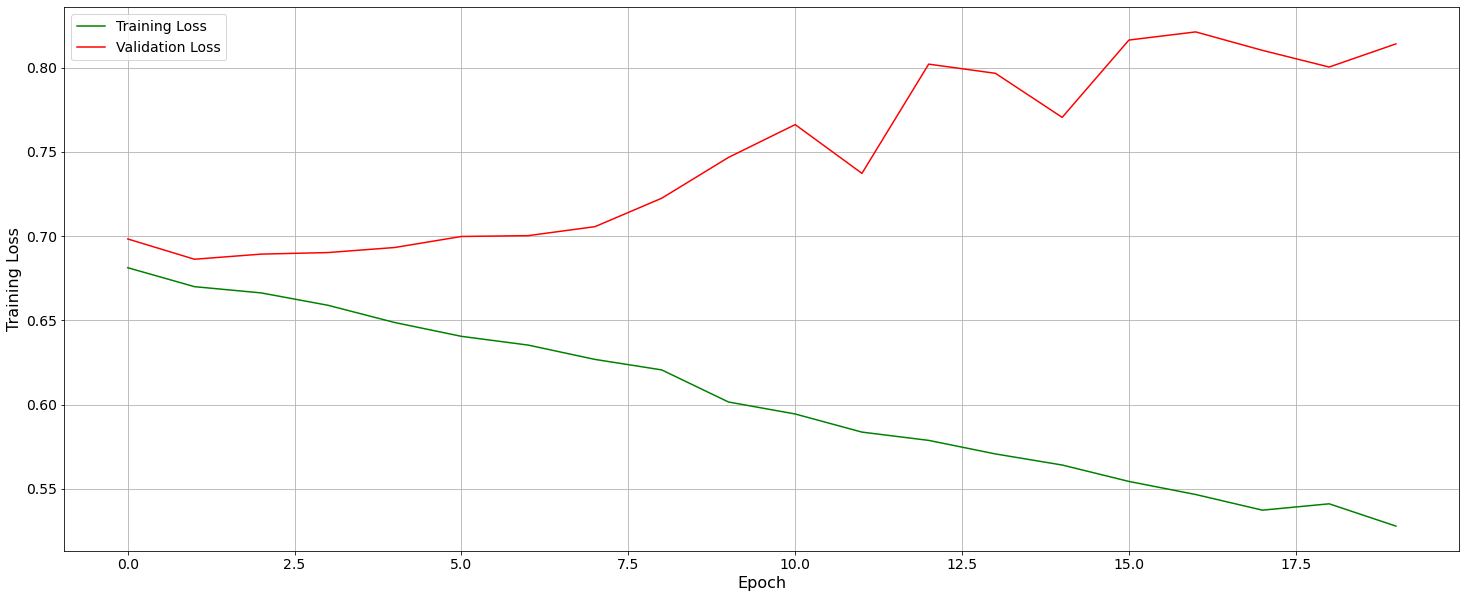

In [72]:
plot_epoch_loss(losses_train[0.0001])

In [73]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.391892,0.480663,0.330798,0.516129,0.506077
1,0.0001,cluster1,class_scores,0.595745,0.767123,0.486957,0.727599,0.691649
2,0.0001,cluster2,class_scores,0.242187,0.287037,0.209459,0.304659,0.310837


In [74]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.649189,0.812500,0.540541,0.745240,0.722039
1,0.0001,cluster1,class_scores,0.679887,0.863309,0.560748,0.774676,0.747330
2,0.0001,cluster2,class_scores,0.421053,0.476190,0.377358,0.450000,0.454637


## Loss Analysis - Multitask Network

### Using Batch Size of 1 and checking Word Loss

In [138]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.1],
                                                            epochs=10,
                                                            batch_size=1,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.5252690315246582 | Rec Loss : 0.5232288241386414 | Word Loss : 0.020401958376169205
T

In [139]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.618951,0.448175,1.000000,0.448175,0.500000
1,"(0.001, 0.1)",overall,word_scores,0.444291,0.425447,0.464881,0.476532,0.475475
2,"(0.001, 0.1)",cluster1,class_scores,0.599087,0.427640,1.000000,0.427640,0.500000
3,"(0.001, 0.1)",cluster1,word_scores,0.457815,0.440160,0.476945,0.488918,0.487877
4,"(0.001, 0.1)",cluster2,class_scores,0.638260,0.468709,1.000000,0.468709,0.500000
5,"(0.001, 0.1)",cluster2,word_scores,0.430748,0.410832,0.452693,0.464146,0.463064


In [140]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.614067,0.443071,1.000000,0.443071,0.500000
1,"(0.001, 0.1)",overall,word_scores,0.448223,0.429984,0.468077,0.470588,0.470400
2,"(0.001, 0.1)",cluster1,class_scores,0.609200,0.438021,1.000000,0.438021,0.500000
3,"(0.001, 0.1)",cluster1,word_scores,0.447739,0.429613,0.467460,0.473360,0.472890
4,"(0.001, 0.1)",cluster2,class_scores,0.660996,0.493648,1.000000,0.493648,0.500000
5,"(0.001, 0.1)",cluster2,word_scores,0.452763,0.433447,0.473881,0.442831,0.443654


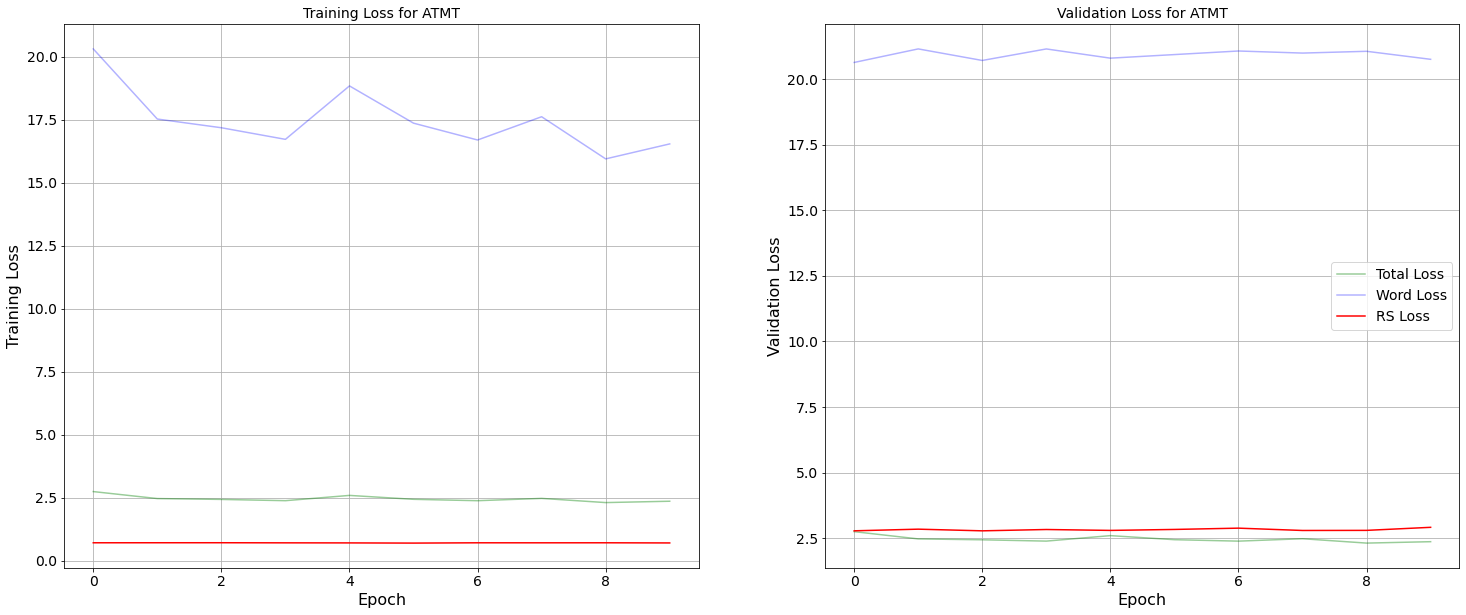

In [141]:
plot_epoch_loss_multi(losses_train[(0.001,0.1)])

### Using Larger Batch Size and Checking Word Loss

In [148]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.1],
                                                            epochs=10,
                                                            batch_size=8,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.9272388219833374 | Rec Loss : 0.7251465320587158 | Word Loss : 2.0209226608276367
Tru

In [149]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.573279,0.455794,0.772364,0.484681,0.511699
1,"(0.001, 0.1)",overall,word_scores,0.499386,0.433600,0.588704,0.468709,0.479592
2,"(0.001, 0.1)",cluster1,class_scores,0.633826,0.494449,0.882622,0.563885,0.604181
3,"(0.001, 0.1)",cluster1,word_scores,0.499693,0.435294,0.586455,0.468709,0.478942
4,"(0.001, 0.1)",cluster2,class_scores,0.514377,0.416739,0.671766,0.405476,0.421159
5,"(0.001, 0.1)",cluster2,word_scores,0.499078,0.431915,0.590975,0.468709,0.480257


In [150]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.645011,0.510745,0.875046,0.573241,0.604091
1,"(0.001, 0.1)",overall,word_scores,0.501828,0.436176,0.590746,0.461196,0.470929
2,"(0.001, 0.1)",cluster1,class_scores,0.653067,0.514401,0.894084,0.583907,0.618116
3,"(0.001, 0.1)",cluster1,word_scores,0.498061,0.433011,0.586111,0.460493,0.470507
4,"(0.001, 0.1)",cluster2,class_scores,0.566372,0.472906,0.705882,0.466425,0.469429
5,"(0.001, 0.1)",cluster2,word_scores,0.537125,0.465753,0.634328,0.468240,0.472641


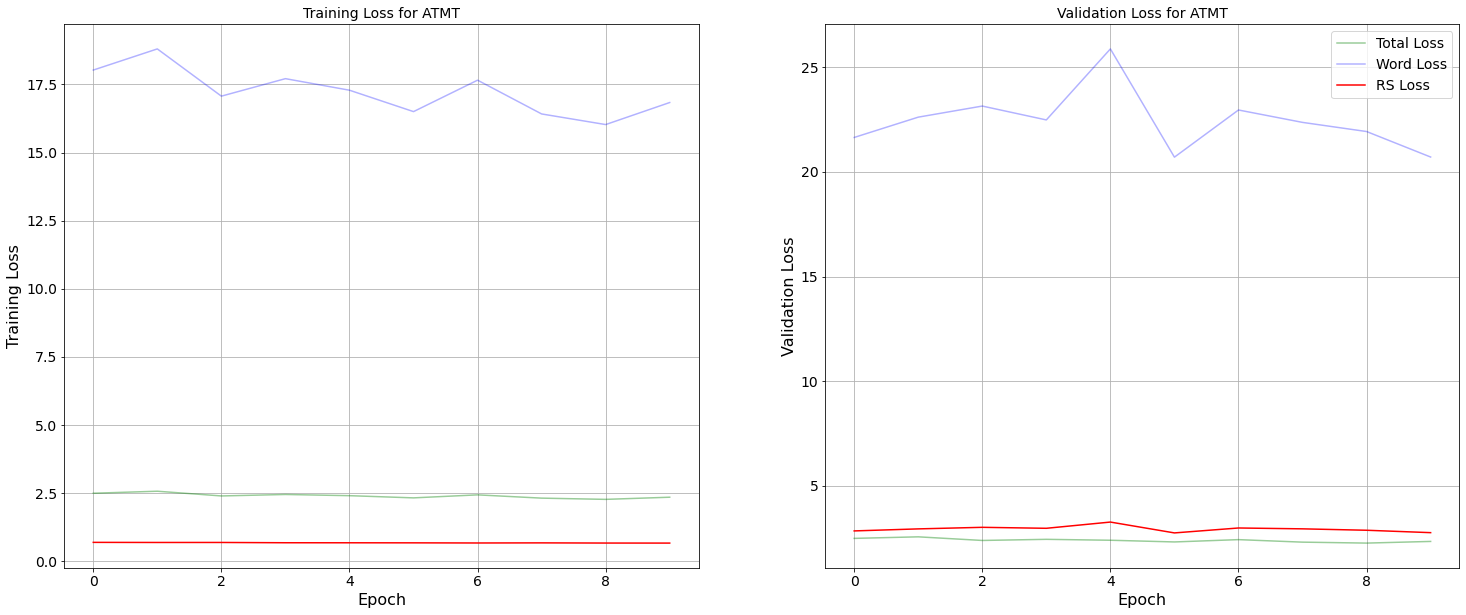

In [151]:
plot_epoch_loss_multi(losses_train[(0.001,0.1)])

## Using Tanh Activation when calculating Attention Weights

In [155]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[2.0],
                                                            epochs=10,
                                                            batch_size=8,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 79.69374084472656 | Rec Loss : 0.7012964487075806 | Word Loss : 39.49622344970703
True 

In [156]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 2.0)",overall,class_scores,0.523520,0.467429,0.594909,0.514668,0.522204
1,"(0.001, 2.0)",overall,word_scores,0.514353,0.434935,0.629254,0.465124,0.480009
2,"(0.001, 2.0)",cluster1,class_scores,0.627923,0.558859,0.716463,0.636897,0.646956
3,"(0.001, 2.0)",cluster1,word_scores,0.517994,0.438561,0.632565,0.467405,0.481759
4,"(0.001, 2.0)",cluster2,class_scores,0.427518,0.382838,0.484006,0.392438,0.397831
5,"(0.001, 2.0)",cluster2,word_scores,0.510689,0.431294,0.625910,0.462842,0.478244


In [157]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 2.0)",overall,class_scores,0.628003,0.566348,0.704723,0.630087,0.637717
1,"(0.001, 2.0)",overall,word_scores,0.517337,0.436867,0.634146,0.456418,0.469771
2,"(0.001, 2.0)",cluster1,class_scores,0.645232,0.580304,0.726520,0.650054,0.658488
3,"(0.001, 2.0)",cluster1,word_scores,0.515098,0.434250,0.632937,0.455781,0.469904
4,"(0.001, 2.0)",cluster2,class_scores,0.469595,0.434375,0.511029,0.430127,0.431142
5,"(0.001, 2.0)",cluster2,word_scores,0.538941,0.462567,0.645522,0.462795,0.467638


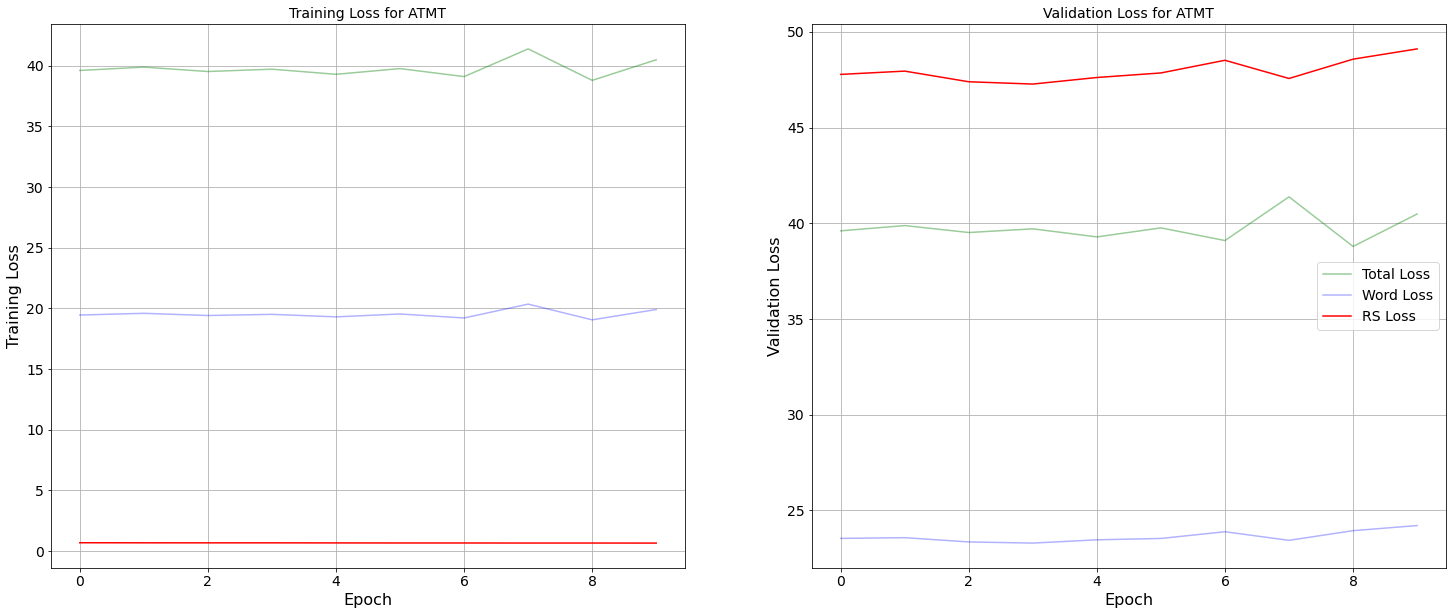

In [158]:
plot_epoch_loss_multi(losses_train[(0.001,2.0)])

## Adding a Linear Layer for the Context Word Network

In [163]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=10,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.9412420988082886 | Rec Loss : 0.6499232649803162 | Word Loss : 0.7282971143722534
Tru

In [164]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.567347,0.532907,0.606545,0.585398,0.587384
1,"(0.001, 0.4)",overall,word_scores,0.387737,0.513740,0.311369,0.557366,0.535056
2,"(0.001, 0.4)",cluster1,class_scores,0.749819,0.715076,0.788110,0.775098,0.776743
3,"(0.001, 0.4)",cluster1,word_scores,0.349386,0.506849,0.266571,0.550847,0.526142
4,"(0.001, 0.4)",cluster2,class_scores,0.406150,0.376485,0.440890,0.395698,0.398359
5,"(0.001, 0.4)",cluster2,word_scores,0.422778,0.519068,0.356623,0.563885,0.544309


In [165]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.742755,0.715615,0.772034,0.763058,0.763976
1,"(0.001, 0.4)",overall,word_scores,0.458673,0.653616,0.353300,0.616906,0.597101
2,"(0.001, 0.4)",cluster1,class_scores,0.778044,0.751639,0.806372,0.798478,0.799348
3,"(0.001, 0.4)",cluster1,word_scores,0.448105,0.656705,0.340079,0.617434,0.595323
4,"(0.001, 0.4)",cluster2,class_scores,0.437931,0.412338,0.466912,0.408348,0.409083
5,"(0.001, 0.4)",cluster2,word_scores,0.544681,0.633663,0.477612,0.611615,0.608064


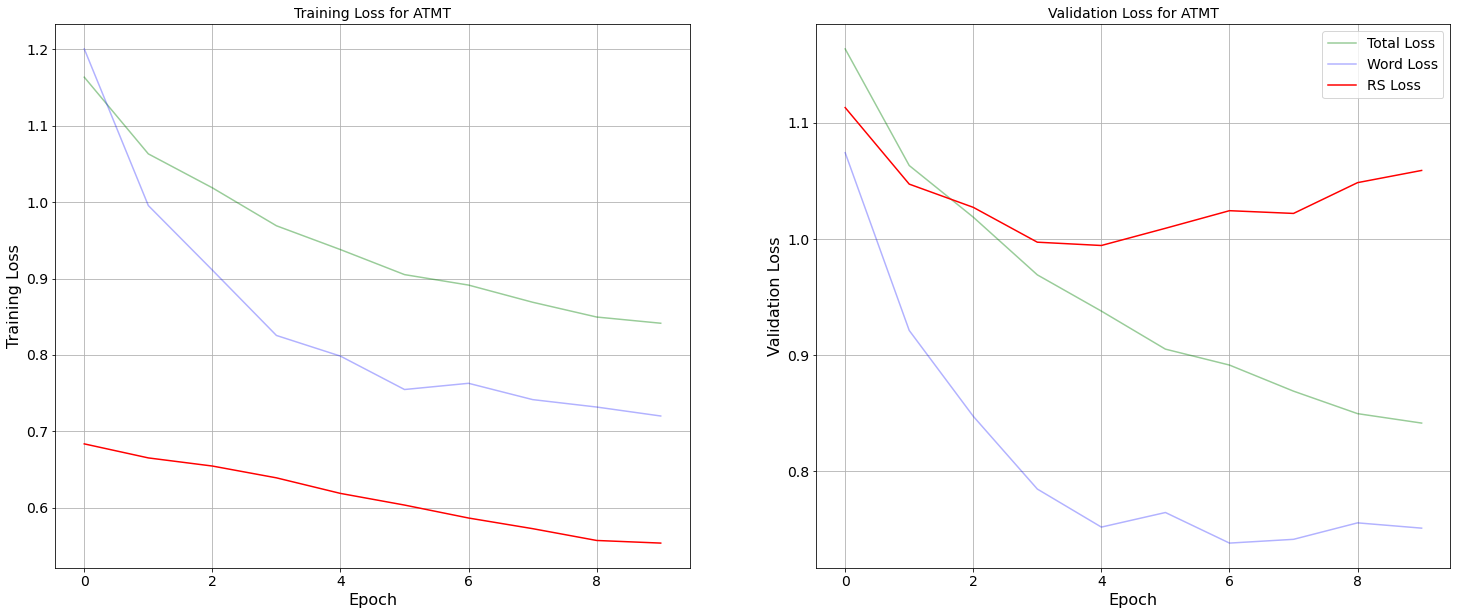

In [166]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

## Using an Extra Attention Layer + Linear Layer for the Context Word Network

In [170]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=10,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 1.0175533294677734 | Rec Loss : 0.6791344881057739 | Word Loss : 0.846047043800354
True

In [171]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.669382,0.681750,0.657455,0.708931,0.704096
1,"(0.001, 0.4)",overall,word_scores,0.662079,0.662319,0.661839,0.695893,0.692805
2,"(0.001, 0.4)",cluster1,class_scores,0.825077,0.838050,0.812500,0.852673,0.847594
3,"(0.001, 0.4)",cluster1,word_scores,0.810207,0.907143,0.731988,0.844850,0.835042
4,"(0.001, 0.4)",cluster2,class_scores,0.526615,0.537681,0.515994,0.565189,0.562292
5,"(0.001, 0.4)",cluster2,word_scores,0.538819,0.495122,0.590975,0.546936,0.551096


In [172]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
1,"(0.001, 0.4)",overall,word_scores,0.988134,0.990627,0.985653,0.989125,0.988864
2,"(0.001, 0.4)",cluster1,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
3,"(0.001, 0.4)",cluster1,word_scores,0.987065,0.990020,0.984127,0.988220,0.987894
4,"(0.001, 0.4)",cluster2,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
5,"(0.001, 0.4)",cluster2,word_scores,0.998138,0.996283,1.000000,0.998185,0.998233


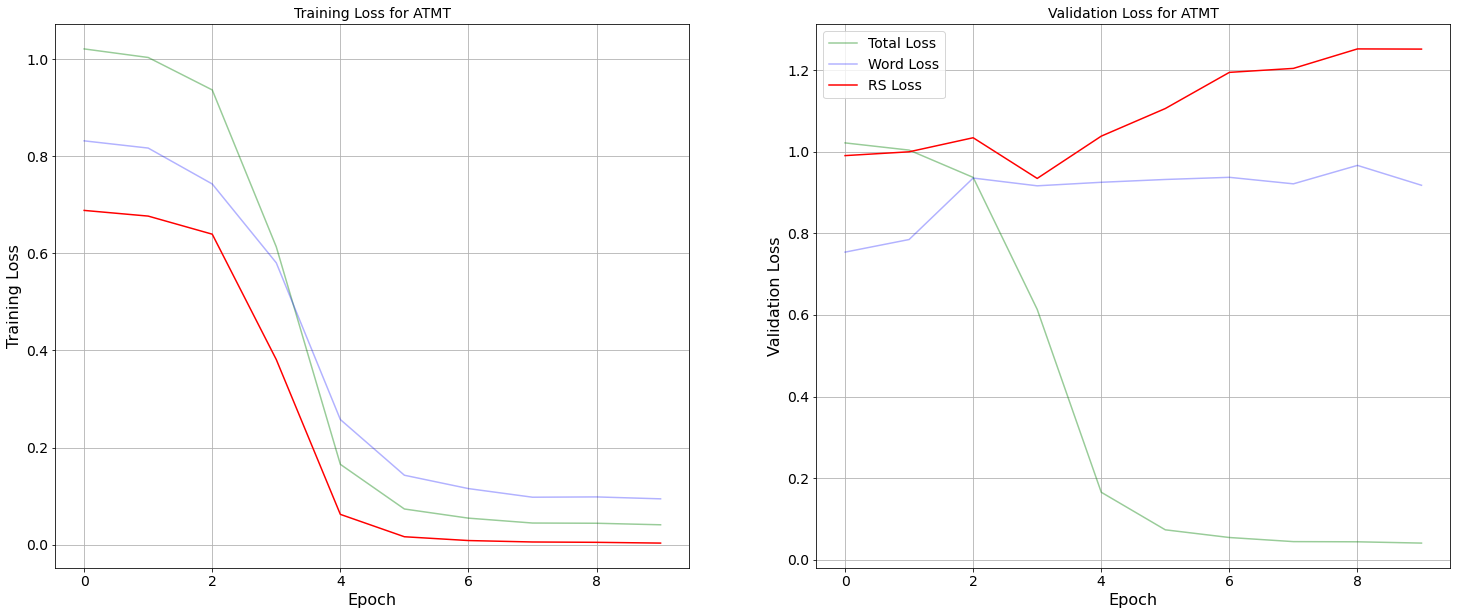

In [173]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

In [176]:
metrics_train,metrics_test, losses_train,model_dict =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=5,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.9615588188171387 | Rec Loss : 0.684438943862915 | Word Loss : 0.6927996277809143
True

In [177]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.643872,0.682410,0.609455,0.697849,0.689547
1,"(0.001, 0.4)",overall,word_scores,0.666667,0.647984,0.686459,0.691004,0.690592
2,"(0.001, 0.4)",cluster1,class_scores,0.818677,0.836248,0.801829,0.848110,0.842259
3,"(0.001, 0.4)",cluster1,word_scores,0.804365,0.876061,0.743516,0.836375,0.828306
4,"(0.001, 0.4)",cluster2,class_scores,0.473445,0.520868,0.433936,0.547588,0.540894
5,"(0.001, 0.4)",cluster2,word_scores,0.553491,0.494279,0.628821,0.545632,0.553490


In [178]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.999814,0.999628,1.000000,0.999835,0.999852
1,"(0.001, 0.4)",overall,word_scores,0.978319,0.977444,0.979197,0.980063,0.979998
2,"(0.001, 0.4)",cluster1,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
3,"(0.001, 0.4)",cluster1,word_scores,0.978377,0.978183,0.978571,0.980246,0.980113
4,"(0.001, 0.4)",cluster2,class_scores,0.998165,0.996337,1.000000,0.998185,0.998208
5,"(0.001, 0.4)",cluster2,word_scores,0.977778,0.970588,0.985075,0.978221,0.978403


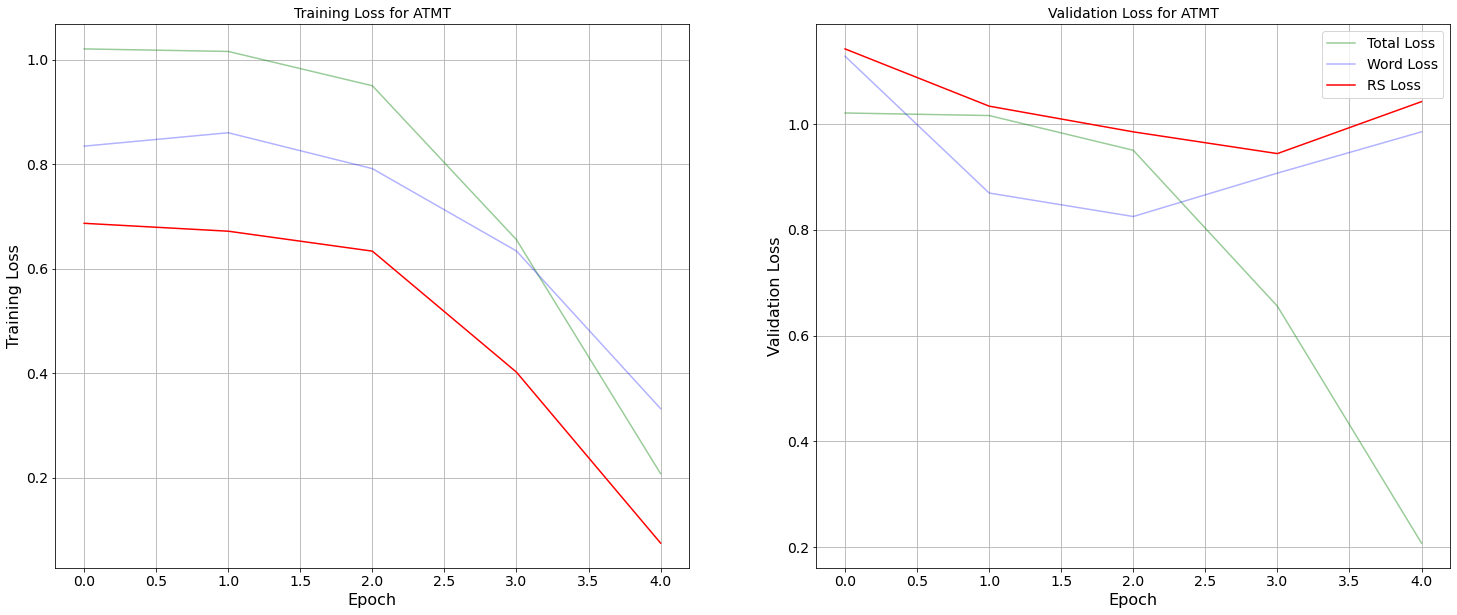

In [179]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

## Checking Attention Weights

### Docs in Cluster 1

In [180]:
doc_ids = doc_2_cluster_map[14]

In [181]:
print(doc_ids[:5])

[0, 9, 64, 94, 242]


In [183]:
display(data.iloc[doc_ids[:5]])

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_
0,Top general warns that 'divisiveness leads to ...,(medianame) America's most senior general warn...,-1.0,0,medianame america most senior general warned ...,top general warns that divisiveness leads to d...,"[defeat, grow, leads]","[incredible, ambiguity, clauses]",False
9,Pompeo recalls Afghan peace envoy after Trump ...,Secretary of State Mike Pompeo said Sunday tha...,1.0,1,secretary state mike pompeo said sunday that t...,pompeo recalls afghan peace envoy after trump ...,"[afghan, envoy, recalls]","[modify, measuring, sitcom]",False
64,White House: Trump's 'second thoughts' on Chin...,President Trump told reporters Sunday that he ...,1.0,1,president trump told reporters sunday that has...,white house trumps second thoughts on china tr...,"[thoughts, greatly, DROP_THIS]","[appearing, epic, honeymoon]",False
94,'None of this is normal': AOC joins other Demo...,Reps. Alexandria Ocasio-Cortez and Ayanna Pres...,-2.0,0,reps alexandria ocasio cortez and ayanna press...,none of this is normal aoc joins other democra...,"[none, boycott, normal]","[spin, loaded, shortened]",False
242,Comey Told Obama that Flynn’s Conversations wi...,Former FBI director James Comey told President...,2.0,1,former fbi director james comey told president...,comey told obama that flynn conversations with...,"[according, conversations, leg]","[regents, flex, rest]",False


In [184]:
display(HTML(data.iloc[doc_ids[:5]].to_html()))

This cluster seems like it talks about US - Foreign Relations

### Docs in cluster 2

In [185]:
doc_ids_2 = doc_2_cluster_map[44]

In [192]:
print(doc_ids_2[-5:])

[94803, 94879, 94899, 94969, 94981]


In [190]:
display(data.iloc[doc_ids_2[-5:]])

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_
94803,Exclusive--Trump Super PAC Releases 'Witch Hun...,The America First Action PAC released a timeli...,2.0,1,the america first action pac released timeline...,exclusivetrump super pac releases witch hunt t...,"[timeline, witch, hunt]","[smashed, scouts, bern]",False
94879,"SHAPIRO: Weirdly, Nancy Pelosi Only Invokes Ca...",On Thursday’s episode of “The reportername Sho...,2.0,1,thursday episode the reportername show the me...,shapiro weirdly nancy pelosi only invokes cath...,"[convenient, weird, shapiro]","[hung, annoying, truman]",False
94899,6 highlights from Ukraine envoy Bill Taylor's ...,President Donald Trump has insisted there was ...,-1.0,0,president donald trump has insisted there was ...,highlights from ukraine envoy bill taylors ex...,"[highlights, envoy, taylor]","[compass, bounce, resigned]",False
94969,Rose McGowan Calls on Joe Biden to Drop Out as...,Joe Biden has most of corporate Hollywood and ...,2.0,1,joe biden has most corporate hollywood and gro...,rose mcgowan calls on joe biden to drop out as...,"[rose, roi, drop]","[enabled, undertaking, filmmakers]",False
94981,Justin Amash becomes the first Republican in C...,Michigan Republican Rep. Justin Amash thinks P...,-2.0,0,michigan republican rep justin amash thinks pr...,justin amash becomes the first republican in c...,"[becomes, conduct, ama]","[connor, hammering, expression]",False


In [191]:
display(HTML(data.iloc[doc_ids_2[-5:]].to_html()))

 Cluster seems about joe biden

## Attention Weight Check

In [196]:
tokenizer = load_tokenizer()

In [193]:
test_article = data["processed_text"].iloc[94981]

In [197]:
test_word = "conduct"

In [194]:
test_article

'michigan republican rep justin amash thinks president donald trump conduct office impeachable that attorney general william barr knowingly misled the public about the conclusions special counsel robert mueller report and that his republican colleagues congress are turning blind eye all contrary barr portrayal mueller report reveals that president trump engaged specific actions and pattern behavior that meet the threshold for impeachment amash tweeted lengthy thread saturday becoming the first and only congressional republican argue that the fbi investigation into trump campaign and its alleged connection russian officials established grounds for impeachment while several prominent democrats have also called for impeachment house speaker nancy pelosi has repeatedly sidestepped the issue instead calling for more investigations amash sits nexus the republican party libertarian who known for breaking from the party line and has partnered with democrats the past but also the house freedom 

In [216]:
sample_df = data.iloc[94981].to_frame().T
sample_df["context_word"] = "conduct"
sample_df["class_label"] = 1
sample_df["word_label"] = 1
sample_df["which_cluster"] = 2

In [217]:
sample_df

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_,context_word,class_label,word_label,which_cluster
94981,Justin Amash becomes the first Republican in C...,Michigan Republican Rep. Justin Amash thinks P...,-2,0,michigan republican rep justin amash thinks pr...,justin amash becomes the first republican in c...,"[becomes, conduct, ama]","[connor, hammering, expression]",False,conduct,1,1,2


In [218]:
single_sample_dataset = CPDatasetMT(sample_df)
single_dataloader = DataLoader(single_sample_dataset,batch_size=1,num_workers=1, shuffle=True)

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'context_word', 'class_label', 'word_label', 'which_cluster'],
      dtype='object')


In [226]:
attention_weights = None
model = model_dict[(0.001,0.4)]
model.eval()
for batch, (x1,x2,y1,y2,wc) in enumerate(single_dataloader):
    x1,x2 = x1.to(torch.device('cuda:1')),x2.to(torch.device('cuda:1'))
    y_pred, context_pred, attention_cvector,attention_weights = model(x1, x2)

In [224]:
attention_cvector.size()

torch.Size([1, 768])

In [227]:
attention_weights.size()

torch.Size([1, 500])

In [238]:
tokens = tokenizer.decode(x1.squeeze().numpy().tolist())

In [241]:
tokens = tokens.split(" ")

In [242]:
len(tokens)

435

In [245]:
tokens = tokens + ["[PAD]"]*65

In [246]:
len(tokens)

500

In [248]:
token_weight_tuples = []
for token,att_w in zip(tokens,attention_weights.squeeze().cpu().detach().numpy().tolist()):
    token_weight_tuples.append((token,att_w))

In [250]:
print("Top 10 highest Attention Weights")
print(sorted(token_weight_tuples,key=lambda x: x[1],reverse=True)[:10])

Top 10 highest Attention Weights
[('william', 0.05006416141986847), ('that', 0.048424068838357925), ('far', 0.04227188974618912), ('unwavering', 0.04022790491580963), ('conclusions', 0.038410067558288574), ('mueller', 0.03578826040029526), ('while', 0.033043909817934036), ('republicans', 0.032495271414518356), ('caucus,', 0.031124096363782883), ('with', 0.029742147773504257)]


In [252]:
print("Top 10 Lowest Attention Weights")
print(sorted(token_weight_tuples,key=lambda x: x[1],reverse=False)[:10])

Top 10 Lowest Attention Weights
[('s', -0.054843030869960785), ('made', -0.05226673558354378), ('’', -0.04446795582771301), ('actions', -0.04262540489435196), ('conclusions', -0.04256197065114975), ('from', -0.04111357405781746), ('trump', -0.040636610239744186), ('congress', -0.03712286800146103), ('he', -0.03625140339136124), ('may', -0.036070920526981354)]


## Using an Extra Attention Layer + Linear Layer for the Context Word Network - Combining and Using Softmax after that

In [271]:
metrics_train,metrics_test, losses_train, model_dict =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=5,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 1.4847896099090576 | Rec Loss : 0.7021770477294922 | Word Loss : 1.956531286239624
True

In [272]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.499826,0.478088,0.523636,0.530313,0.529686
1,"(0.001, 0.4)",overall,word_scores,0.358099,0.493639,0.280956,0.546610,0.522517
2,"(0.001, 0.4)",cluster1,class_scores,0.640364,0.637462,0.643293,0.691004,0.684972
3,"(0.001, 0.4)",cluster1,word_scores,0.290481,0.455385,0.213256,0.528683,0.501271
4,"(0.001, 0.4)",cluster2,class_scores,0.381318,0.353081,0.414465,0.369622,0.372263
5,"(0.001, 0.4)",cluster2,word_scores,0.418118,0.520607,0.349345,0.564537,0.544212


In [273]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.631559,0.638889,0.624396,0.677212,0.671813
1,"(0.001, 0.4)",overall,word_scores,0.385335,0.613636,0.280846,0.588400,0.565294
2,"(0.001, 0.4)",cluster1,class_scores,0.654684,0.669550,0.640463,0.704059,0.697046
3,"(0.001, 0.4)",cluster1,word_scores,0.383838,0.615048,0.278968,0.590975,0.566102
4,"(0.001, 0.4)",cluster2,class_scores,0.445578,0.414557,0.481618,0.408348,0.409268
5,"(0.001, 0.4)",cluster2,word_scores,0.399002,0.601504,0.298507,0.562613,0.555614


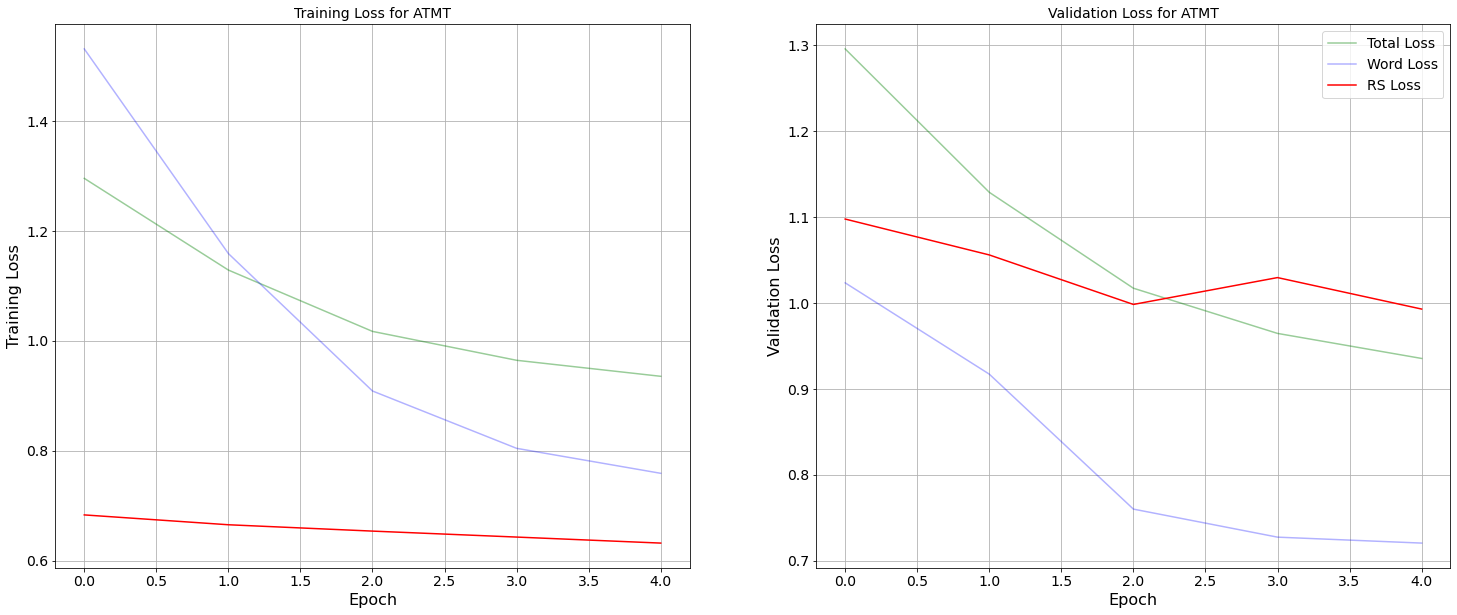

In [274]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

## Using an Extra Attention Layer + Linear Layer for the Context Word Network + Dropout

In [286]:
metrics_train,metrics_test, losses_train, model_dict =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=5,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.9460828304290771 | Rec Loss : 0.6722955703735352 | Word Loss : 0.6844680309295654
Tru

In [287]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.671141,0.688600,0.654545,0.712516,0.707072
1,"(0.001, 0.4)",overall,word_scores,0.656172,0.648515,0.664012,0.686767,0.684703
2,"(0.001, 0.4)",cluster1,class_scores,0.847484,0.875000,0.821646,0.873533,0.866974
3,"(0.001, 0.4)",cluster1,word_scores,0.786499,0.863793,0.721902,0.822686,0.813927
4,"(0.001, 0.4)",cluster2,class_scores,0.512057,0.522431,0.502086,0.551499,0.548589
5,"(0.001, 0.4)",cluster2,word_scores,0.547009,0.498801,0.605531,0.550847,0.556012


In [288]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.994422,0.994422,0.994422,0.995057,0.994992
1,"(0.001, 0.4)",overall,word_scores,0.958889,0.964104,0.953730,0.962432,0.961778
2,"(0.001, 0.4)",cluster1,class_scores,0.994621,0.994621,0.994621,0.995288,0.995215
3,"(0.001, 0.4)",cluster1,word_scores,0.962030,0.969002,0.955159,0.965567,0.964737
4,"(0.001, 0.4)",cluster2,class_scores,0.992647,0.992647,0.992647,0.992740,0.992739
5,"(0.001, 0.4)",cluster2,word_scores,0.929889,0.919708,0.940299,0.931034,0.931280


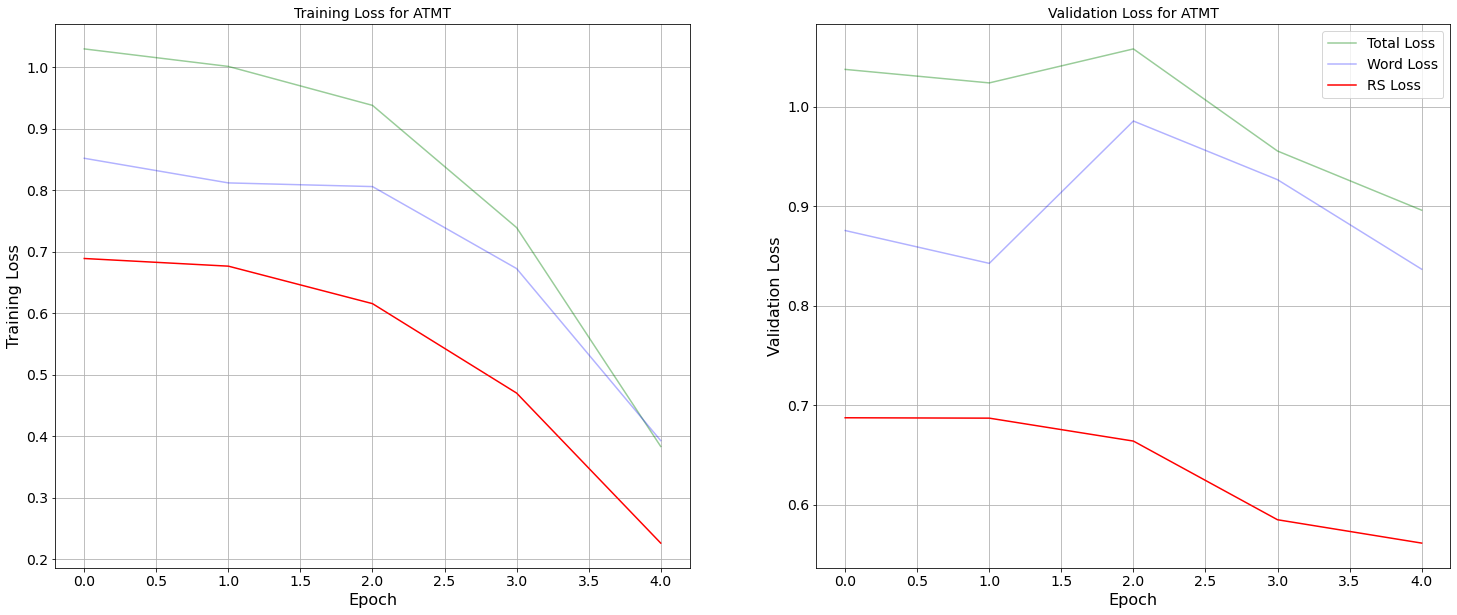

In [289]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

In [310]:
metrics_train,metrics_test, losses_train, model_dict =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=5,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 1.133592128753662 | Rec Loss : 0.7210898399353027 | Word Loss : 1.0312556028366089
True

In [311]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.676912,0.681149,0.672727,0.712190,0.708484
1,"(0.001, 0.4)",overall,word_scores,0.661433,0.625565,0.701665,0.676662,0.678930
2,"(0.001, 0.4)",cluster1,class_scores,0.849462,0.856037,0.842988,0.872229,0.868533
3,"(0.001, 0.4)",cluster1,word_scores,0.802742,0.851373,0.759366,0.831160,0.824921
4,"(0.001, 0.4)",cluster2,class_scores,0.519916,0.522472,0.517385,0.552151,0.550104
5,"(0.001, 0.4)",cluster2,word_scores,0.546691,0.475269,0.643377,0.522164,0.533613


In [312]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.999814,0.999628,1.000000,0.999835,0.999852
1,"(0.001, 0.4)",overall,word_scores,0.965419,0.959603,0.971306,0.968034,0.968280
2,"(0.001, 0.4)",cluster1,class_scores,0.999793,0.999586,1.000000,0.999819,0.999839
3,"(0.001, 0.4)",cluster1,word_scores,0.966772,0.963722,0.969841,0.969554,0.969577
4,"(0.001, 0.4)",cluster2,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
5,"(0.001, 0.4)",cluster2,word_scores,0.953069,0.923077,0.985075,0.952813,0.953668


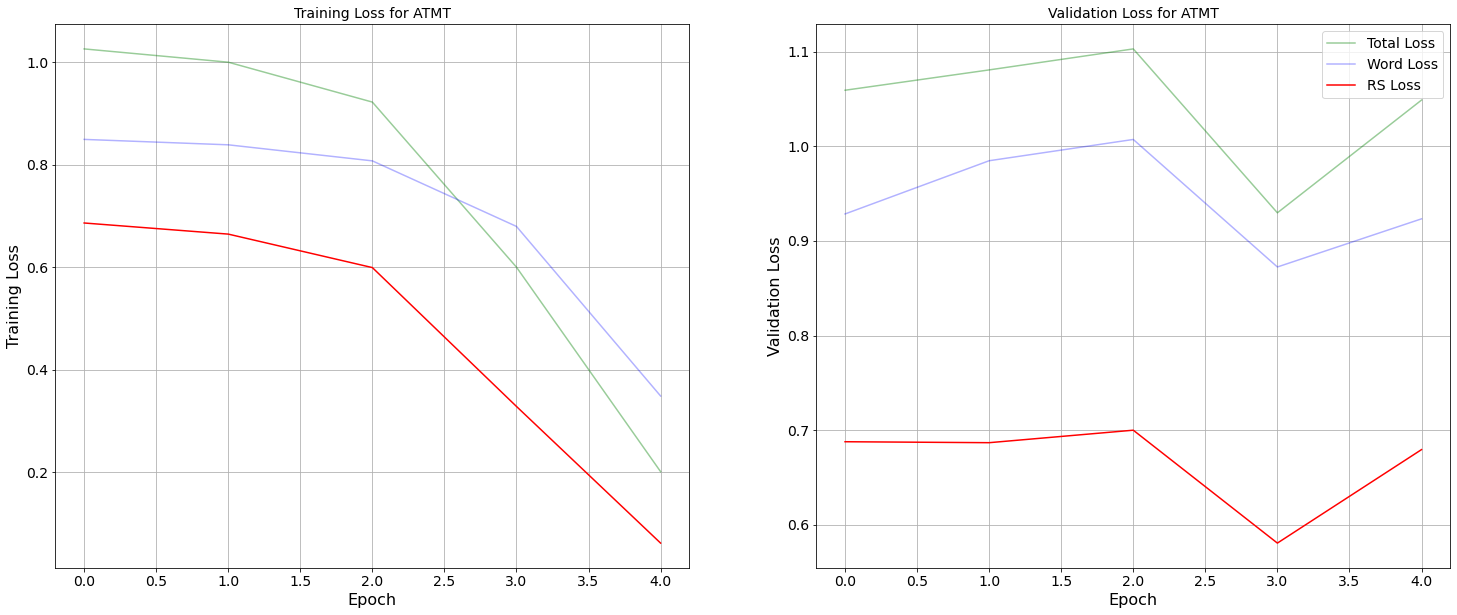

In [313]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

## Model Checkpointing For Multitask Network and Single Task Network

In [ ]:
## This needs some thought
# Save model after each epoch - need a way to generate a bunch of paths 
# Create a folder for a cluster pair
# Create a folder for a hyperparameter combination
# Create a folder for checkpoints, and one for results (Train and Test) Metrics
# save the checkpoints - name should have this format (epoch_model)
# Avg the model and save it under hyperparameter combination folder

# During averaging use 
# # for name, param in test_b.named_parameters():
#     print(name)
# to average only the non-bert layers

In [32]:
scores_test, losses_train, scores_train, scores_test_att, losses_train_att, scores_train_att, scores_test_multi, losses_train_multi, scores_train_multi = load_results(cluster_pair=(14,44))

In [33]:
print_res(scores_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.508108,0.482877,0.536122,0.510753,0.512129
1,0.0010,cluster1,class_scores,0.561983,0.535433,0.591304,0.620072,0.615774
2,0.0010,cluster2,class_scores,0.466454,0.442424,0.493243,0.401434,0.395477
3,0.0001,overall,class_scores,0.138365,0.400000,0.083650,0.508961,0.485893
4,0.0001,cluster1,class_scores,0.191176,0.619048,0.113043,0.605735,0.532131
5,0.0001,cluster2,class_scores,0.098901,0.264706,0.060811,0.412186,0.434986


In [34]:
print_res(scores_test_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.417722,0.469194,0.376426,0.505376,0.498382
1,0.0010,cluster1,class_scores,0.447489,0.471154,0.426087,0.566308,0.545361
2,0.0010,cluster2,class_scores,0.392157,0.467290,0.337838,0.444444,0.451362
3,0.0001,overall,class_scores,0.178161,0.364706,0.117871,0.487455,0.467410
4,0.0001,cluster1,class_scores,0.209790,0.535714,0.130435,0.594982,0.525583
5,0.0001,cluster2,class_scores,0.156098,0.280702,0.108108,0.379928,0.397566


In [35]:
print_res(scores_test_multi)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.696104,0.710606,0.682182,0.733051,0.728273
1,"(0.001, 0.1)",overall,word_scores,0.657270,0.673764,0.641564,0.698827,0.693633
2,"(0.001, 0.1)",cluster1,class_scores,0.882353,0.896226,0.868902,0.900913,0.896866
3,"(0.001, 0.1)",cluster1,word_scores,0.783320,0.905482,0.690202,0.827249,0.815339
4,"(0.001, 0.1)",cluster2,class_scores,0.524590,0.538012,0.511822,0.565189,0.562046
5,"(0.001, 0.1)",cluster2,word_scores,0.552614,0.517812,0.592431,0.570404,0.572485
6,"(0.001, 0.4)",overall,class_scores,0.693590,0.706949,0.680727,0.730443,0.725774
7,"(0.001, 0.4)",overall,word_scores,0.644776,0.665127,0.625634,0.689700,0.683890
8,"(0.001, 0.4)",cluster1,class_scores,0.884259,0.895312,0.873476,0.902216,0.898583
9,"(0.001, 0.4)",cluster1,word_scores,0.771615,0.889098,0.681556,0.817471,0.805659


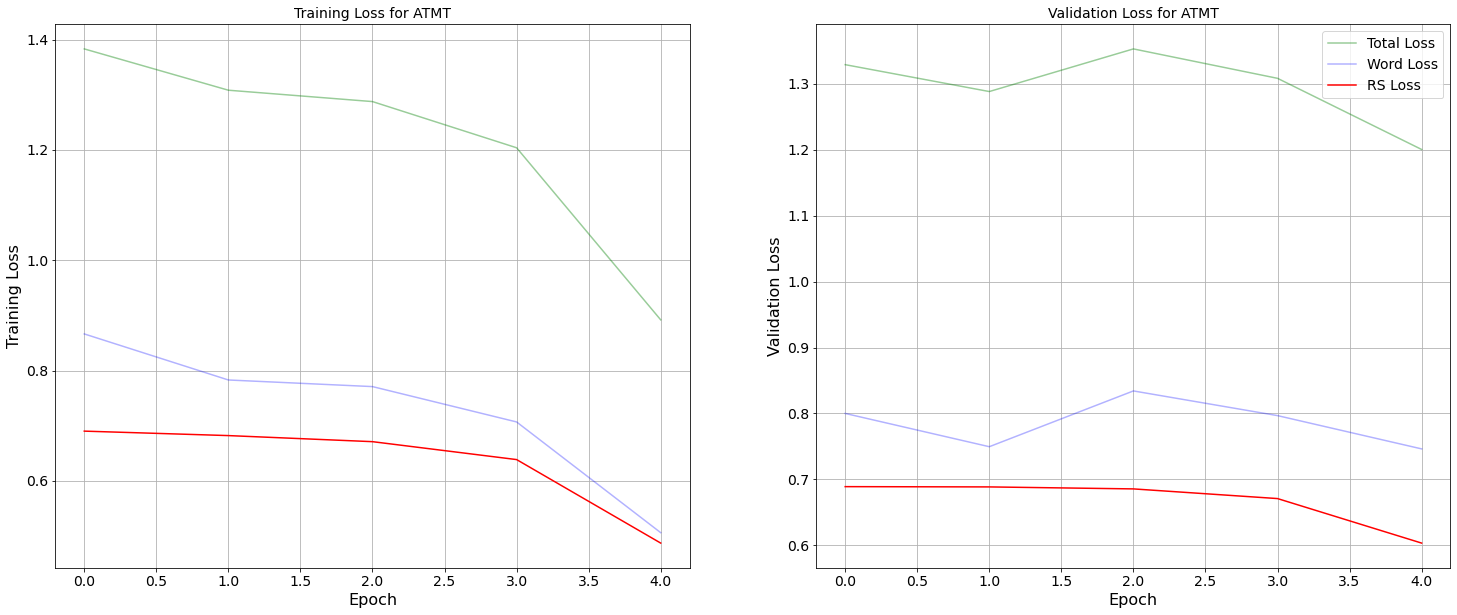

In [39]:
plot_epoch_loss_multi(losses_train_multi[((0.001, 0.8))])

In [21]:
scores_test, losses_train, scores_train, scores_test_att, losses_train_att, scores_train_att, scores_test_multi, losses_train_multi, scores_train_multi = load_results(cluster_pair=(0,30))

In [22]:
print_res(scores_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.292887,0.432099,0.221519,0.517143,0.490968
1,0.0010,cluster1,class_scores,0.323232,0.592593,0.222222,0.617143,0.557713
2,0.0010,cluster2,class_scores,0.271429,0.351852,0.220930,0.417143,0.413836
3,0.0001,overall,class_scores,0.310924,0.462500,0.234177,0.531429,0.505109
4,0.0001,cluster1,class_scores,0.310680,0.516129,0.222222,0.594286,0.538296
5,0.0001,cluster2,class_scores,0.311111,0.428571,0.244186,0.468571,0.464790


In [23]:
print_res(scores_test_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.427586,0.469697,0.392405,0.525714,0.513911
1,0.0010,cluster1,class_scores,0.418605,0.473684,0.375000,0.571429,0.541869
2,0.0010,cluster2,class_scores,0.434783,0.466667,0.406977,0.480000,0.478769
3,0.0001,overall,class_scores,0.260870,0.416667,0.189873,0.514286,0.485562
4,0.0001,cluster1,class_scores,0.257426,0.448276,0.180556,0.571429,0.512608
5,0.0001,cluster2,class_scores,0.263566,0.395349,0.197674,0.457143,0.452770


In [24]:
print_res(scores_test_multi)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.682366,0.692308,0.672707,0.701081,0.699849
1,"(0.001, 0.1)",overall,word_scores,0.596178,0.622340,0.572127,0.657297,0.648467
2,"(0.001, 0.1)",cluster1,class_scores,0.851385,0.842893,0.860051,0.872432,0.870815
3,"(0.001, 0.1)",cluster1,word_scores,0.688112,0.763975,0.625954,0.758919,0.741549
4,"(0.001, 0.1)",cluster2,class_scores,0.540655,0.560175,0.522449,0.529730,0.530190
5,"(0.001, 0.1)",cluster2,word_scores,0.519298,0.516279,0.522353,0.555676,0.553176
6,"(0.001, 0.4)",overall,class_scores,0.621999,0.613436,0.630804,0.634054,0.633913
7,"(0.001, 0.4)",overall,word_scores,0.565722,0.598093,0.536675,0.635676,0.625411
8,"(0.001, 0.4)",cluster1,class_scores,0.744811,0.715962,0.776081,0.774054,0.774319
9,"(0.001, 0.4)",cluster1,word_scores,0.676754,0.736527,0.625954,0.745946,0.730270


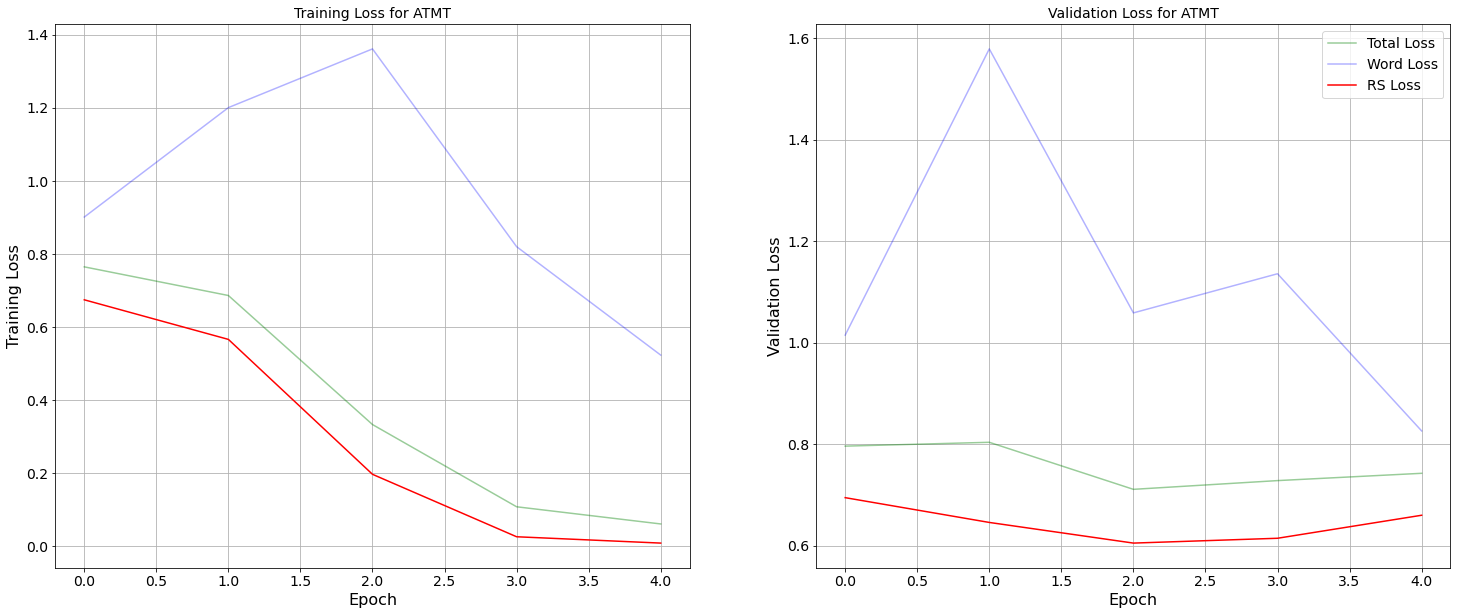

In [31]:
plot_epoch_loss_multi(losses_train_multi[((0.001, 0.1))])

In [40]:
scores_test, losses_train, scores_train, scores_test_att, losses_train_att, scores_train_att, scores_test_multi, losses_train_multi, scores_train_multi = load_results(cluster_pair=(22,36))

In [41]:
print_res(scores_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.168350,0.431034,0.104603,0.511858,0.490504
1,0.0010,cluster1,class_scores,0.152542,0.473684,0.090909,0.604743,0.512987
2,0.0010,cluster2,class_scores,0.178771,0.410256,0.114286,0.418972,0.455373
3,0.0001,overall,class_scores,0.061776,0.400000,0.033473,0.519763,0.494264
4,0.0001,cluster1,class_scores,0.038462,0.400000,0.020202,0.604743,0.500361
5,0.0001,cluster2,class_scores,0.077419,0.400000,0.042857,0.434783,0.481606


In [42]:
print_res(scores_test_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.326087,0.465116,0.251046,0.509881,0.496310
1,0.0010,cluster1,class_scores,0.314465,0.416667,0.252525,0.569170,0.512626
2,0.0010,cluster2,class_scores,0.334928,0.507246,0.250000,0.450593,0.474558
3,0.0001,overall,class_scores,0.000000,0.000000,0.000000,0.527668,0.500000
4,0.0001,cluster1,class_scores,0.000000,0.000000,0.000000,0.608696,0.500000
5,0.0001,cluster2,class_scores,0.000000,0.000000,0.000000,0.446640,0.500000


In [43]:
print_res(scores_test_multi)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.692155,0.725982,0.661339,0.721742,0.718648
1,"(0.001, 0.1)",overall,word_scores,0.666667,0.662844,0.670534,0.687905,0.686782
2,"(0.001, 0.1)",cluster1,class_scores,0.882613,0.889680,0.875657,0.904248,0.899931
3,"(0.001, 0.1)",cluster1,word_scores,0.805281,0.897059,0.730539,0.830094,0.826435
4,"(0.001, 0.1)",cluster2,class_scores,0.535559,0.581102,0.496635,0.539237,0.542435
5,"(0.001, 0.1)",cluster2,word_scores,0.545716,0.496073,0.606400,0.545716,0.551237
6,"(0.001, 0.4)",overall,class_scores,0.643619,0.732750,0.573820,0.699424,0.692989
7,"(0.001, 0.4)",overall,word_scores,0.666924,0.665639,0.668213,0.689345,0.687979
8,"(0.001, 0.4)",cluster1,class_scores,0.844322,0.884837,0.807356,0.877610,0.867003
9,"(0.001, 0.4)",cluster1,word_scores,0.782178,0.871324,0.709581,0.809935,0.806247


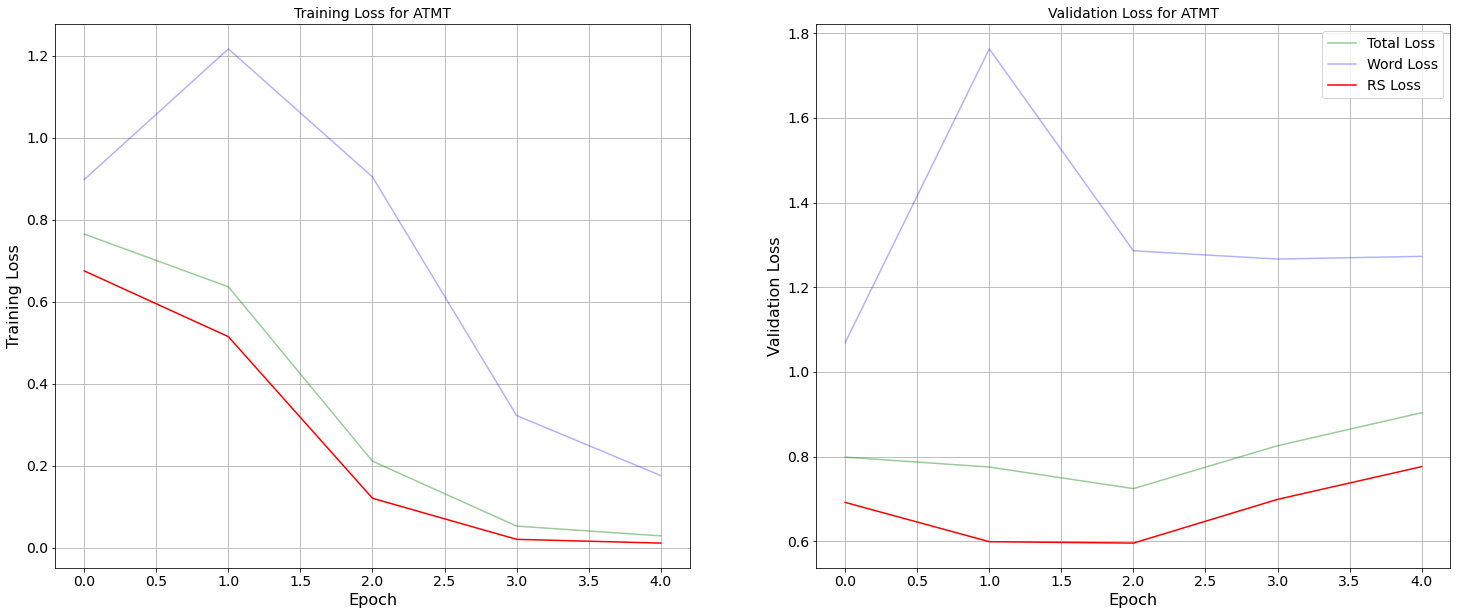

In [44]:
plot_epoch_loss_multi(losses_train_multi[((0.001, 0.1))])

In [45]:
scores_test, losses_train, scores_train, scores_test_att, losses_train_att, scores_train_att, scores_test_multi, losses_train_multi, scores_train_multi = load_results(cluster_pair=(22,58))

In [46]:
print_res(scores_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.093750,0.352941,0.054054,0.541502,0.488295
1,0.0010,cluster1,class_scores,0.074766,0.500000,0.040404,0.608696,0.507215
2,0.0010,cluster2,class_scores,0.107383,0.307692,0.065041,0.474308,0.463290
3,0.0001,overall,class_scores,0.000000,0.000000,0.000000,0.559289,0.498239
4,0.0001,cluster1,class_scores,0.000000,0.000000,0.000000,0.608696,0.500000
5,0.0001,cluster2,class_scores,0.000000,0.000000,0.000000,0.509881,0.496154


In [47]:
print_res(scores_test_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.208754,0.413333,0.139640,0.535573,0.492355
1,0.0010,cluster1,class_scores,0.220472,0.500000,0.141414,0.608696,0.525253
2,0.0010,cluster2,class_scores,0.200000,0.361702,0.138211,0.462451,0.453721
3,0.0001,overall,class_scores,0.000000,0.000000,0.000000,0.561265,0.500000
4,0.0001,cluster1,class_scores,0.000000,0.000000,0.000000,0.608696,0.500000
5,0.0001,cluster2,class_scores,0.000000,0.000000,0.000000,0.513834,0.500000


In [48]:
print_res(scores_test_multi)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.687708,0.727592,0.651969,0.729302,0.723199
1,"(0.001, 0.1)",overall,word_scores,0.671964,0.670189,0.673748,0.687905,0.687217
2,"(0.001, 0.1)",cluster1,class_scores,0.860196,0.875000,0.845884,0.886969,0.880766
3,"(0.001, 0.1)",cluster1,word_scores,0.781533,0.869725,0.709581,0.809215,0.805553
4,"(0.001, 0.1)",cluster2,class_scores,0.536965,0.588737,0.493562,0.571634,0.572143
5,"(0.001, 0.1)",cluster2,word_scores,0.579021,0.530769,0.636923,0.566595,0.570830
6,"(0.001, 0.4)",overall,class_scores,0.651341,0.708990,0.602362,0.705184,0.697070
7,"(0.001, 0.4)",overall,word_scores,0.674953,0.670157,0.679818,0.689345,0.688882
8,"(0.001, 0.4)",cluster1,class_scores,0.822682,0.846296,0.800350,0.858171,0.849442
9,"(0.001, 0.4)",cluster1,word_scores,0.802932,0.880357,0.738024,0.825774,0.822549


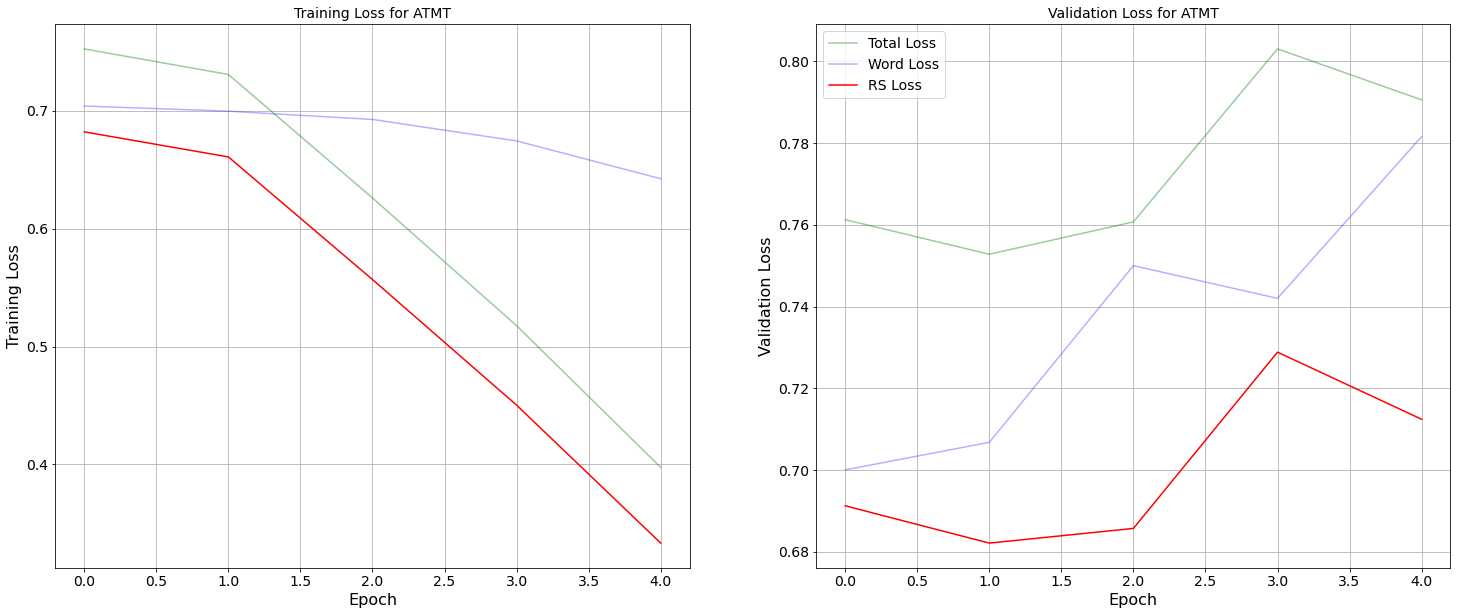

In [52]:
plot_epoch_loss_multi(losses_train_multi[((0.0001, 0.1))])

In [7]:
scores_test, losses_train, scores_train, scores_test_att, losses_train_att, scores_train_att, scores_test_multi, losses_train_multi, scores_train_multi = load_results(cluster_pair=(1,22))

In [8]:
print_res(scores_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.408889,0.597403,0.310811,0.511029,0.530405
1,0.0010,cluster1,class_scores,0.554545,0.709302,0.455224,0.639706,0.637032
2,0.0010,cluster2,class_scores,0.269565,0.455882,0.191358,0.382353,0.427497
3,0.0001,overall,class_scores,0.020000,0.750000,0.010135,0.459559,0.503051
4,0.0001,cluster1,class_scores,0.000000,0.000000,0.000000,0.507353,0.500000
5,0.0001,cluster2,class_scores,0.036145,0.750000,0.018519,0.411765,0.504714


In [9]:
print_res(scores_test_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0010,overall,class_scores,0.331707,0.596491,0.229730,0.496324,0.522123
1,0.0010,cluster1,class_scores,0.404145,0.661017,0.291045,0.577206,0.573059
2,0.0010,cluster2,class_scores,0.267281,0.527273,0.179012,0.415441,0.471324
3,0.0001,overall,class_scores,0.000000,0.000000,0.000000,0.455882,0.500000
4,0.0001,cluster1,class_scores,0.000000,0.000000,0.000000,0.507353,0.500000
5,0.0001,cluster2,class_scores,0.000000,0.000000,0.000000,0.404412,0.500000


In [10]:
print_res(scores_test_multi)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.714911,0.760745,0.674286,0.716533,0.718955
1,"(0.001, 0.1)",overall,word_scores,0.665195,0.670126,0.660336,0.695448,0.692737
2,"(0.001, 0.1)",cluster1,class_scores,0.897126,0.885075,0.909509,0.908969,0.909030
3,"(0.001, 0.1)",cluster1,word_scores,0.799674,0.907579,0.714702,0.835341,0.826372
4,"(0.001, 0.1)",cluster2,class_scores,0.568830,0.646006,0.508126,0.524096,0.529019
5,"(0.001, 0.1)",cluster2,word_scores,0.554362,0.511139,0.605572,0.555556,0.559559
6,"(0.001, 0.4)",overall,class_scores,0.697559,0.787540,0.626032,0.713855,0.718890
7,"(0.001, 0.4)",overall,word_scores,0.669123,0.675093,0.663258,0.699465,0.696669
8,"(0.001, 0.4)",cluster1,class_scores,0.879173,0.912541,0.848160,0.898260,0.892607
9,"(0.001, 0.4)",cluster1,word_scores,0.807566,0.928166,0.714702,0.843373,0.833807


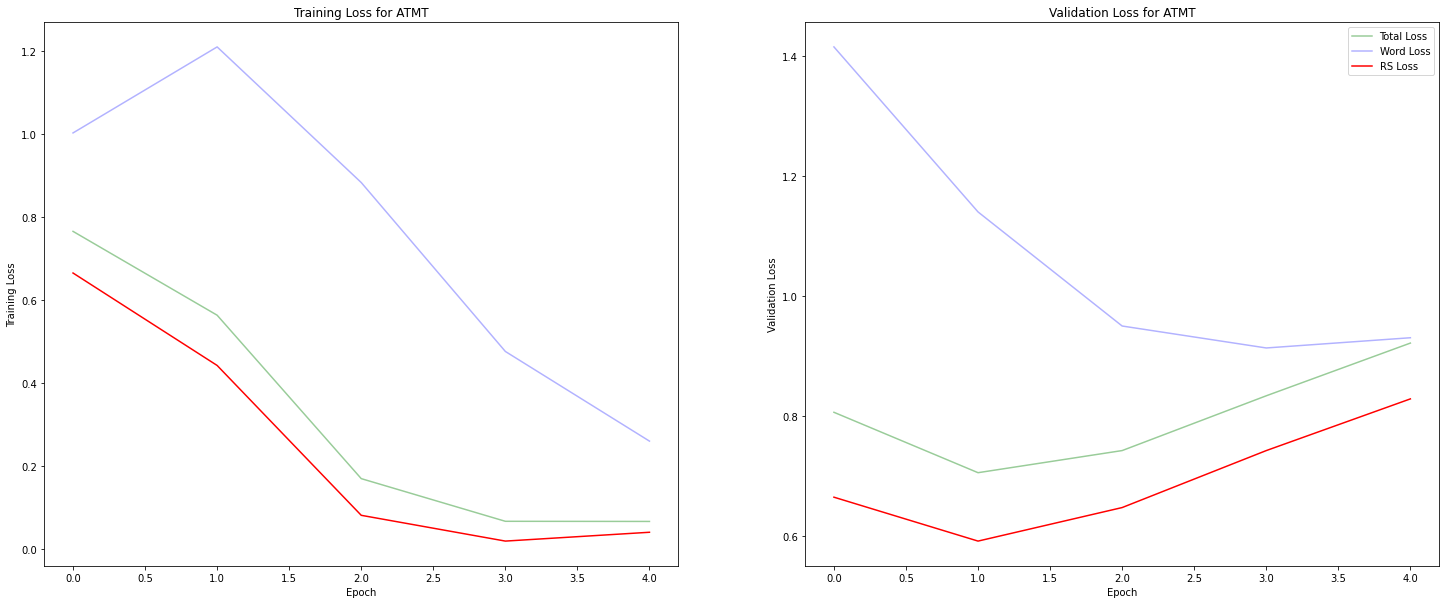

In [12]:
plot_epoch_loss_multi(losses_train_multi[((0.001, 0.1))])

## Attention Weight Analysis

### SingleTask with Attention Model

In [24]:
metrics_train,metrics_test_single, losses_train, model_dict =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=5,
                                                            batch_size=16,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 430
0 : 573

Sample size from C2 in Train : (100, 10)
1 : 48
0 : 52

Train Size : (1103, 10)
1 : 478
0 : 625

Sample Size from C1 in Test : (279, 10)
1 : 119
0 : 160

Sample Size from C2 in Test : (279, 10)
1 : 134
0 : 145

Test Size : (558, 10)
1 : 253
0 : 305

Sample size from C1 in Val : (112, 10)
1 : 48
0 : 64

Sample size from C2 in Val : (112, 10)
1 : 54
0 : 58

Val Size : (224, 10)
1 : 102
0 : 122
Avg Batch Loss Train : 0.6919513958087866
Avg Batch Loss Val : 0.6898686076913562
Avg Batch Loss Train : 0.5091555874416793
Avg Batch Loss Val : 0.7961762206895011
Avg Batch Loss Train : 0.05567127379818239
Avg Batch Loss Val : 0.9726502767630986
Avg Batch Loss Train : 0.004074443059136578
Avg Batch Loss Val : 1.1049799876553672
Avg Batch Loss Train : 0.0017351256531622746
Avg Batch Loss Val : 1.1694588448320116
Y1 Pred Dist : 
1 : 478
0 : 625
Predicted Label Shape : (1103,)


In [27]:
print_res(metrics_test_single)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.415094,0.441964,0.391304,0.500000,0.490734
1,0.001,cluster1,class_scores,0.394850,0.403509,0.386555,0.494624,0.480777
2,0.001,cluster2,class_scores,0.434426,0.481818,0.395522,0.505376,0.501209


### Multitask Model

In [25]:
metrics_train,metrics_test_multi, losses_train, model_dict_multi =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.1],
                                                            epochs=5,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2402
0 : 3116

Sample size from C2 in Train : (551, 5)
1 : 263
0 : 288

Train Size : (6069, 5)
1 : 2665
0 : 3404

Sample Size from C1 in Test : (1534, 5)
1 : 667
0 : 867

Sample Size from C2 in Test : (1534, 5)
1 : 731
0 : 803

Test Size : (3068, 5)
1 : 1398
0 : 1670

Sample size from C1 in Val : (614, 5)
1 : 268
0 : 346

Sample size from C2 in Val : (614, 5)
1 : 293
0 : 321

Val Size : (1228, 5)
1 : 561
0 : 667
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.8146117925643921 | Rec Loss : 0.720056414604187 | Word Loss : 0.9455538392066956
True

In [28]:
print_res(metrics_test_multi)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.736880,0.751114,0.723176,0.764668,0.761289
1,"(0.001, 0.1)",overall,word_scores,0.629672,0.669880,0.594017,0.680248,0.673511
2,"(0.001, 0.1)",cluster1,class_scores,0.917472,0.910029,0.925037,0.927640,0.927340
3,"(0.001, 0.1)",cluster1,word_scores,0.750198,0.838652,0.678623,0.794654,0.784951
4,"(0.001, 0.1)",cluster2,class_scores,0.563259,0.589820,0.538988,0.601695,0.598884
5,"(0.001, 0.1)",cluster2,word_scores,0.520173,0.530103,0.510608,0.565841,0.561834


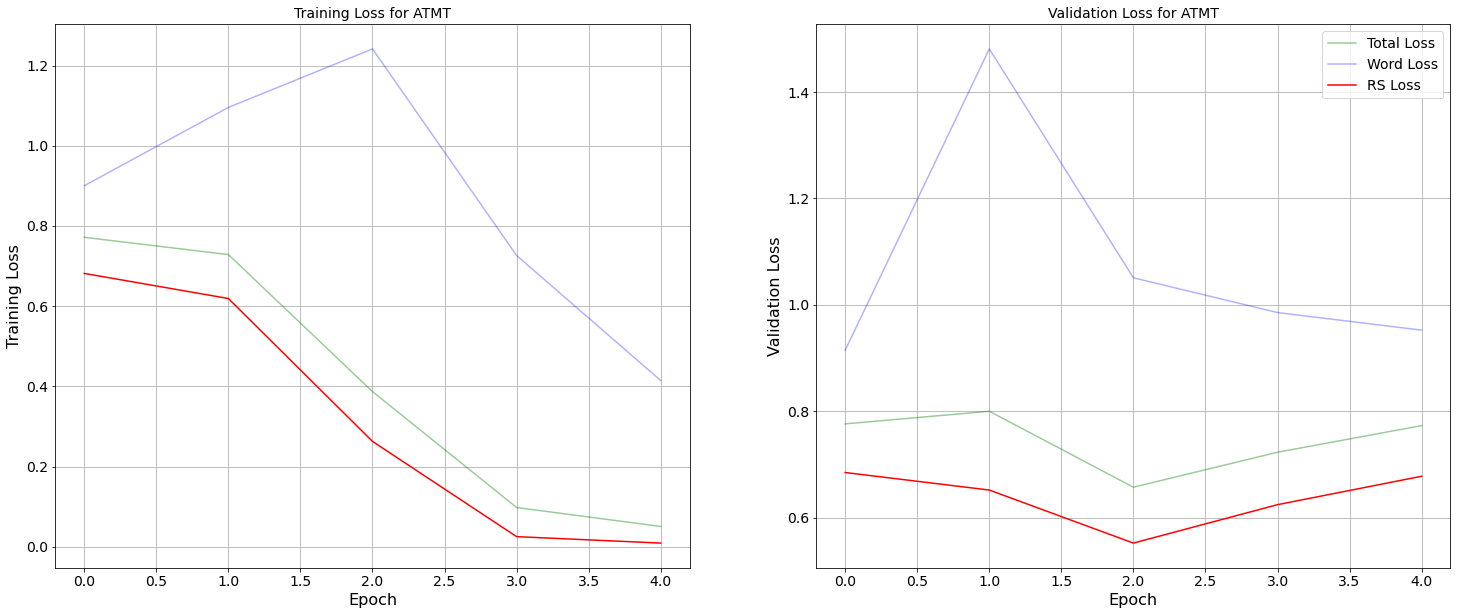

In [29]:
plot_epoch_loss_multi(losses_train[((0.001, 0.1))])

## Attention Weights

## Attention Weight Check

In [196]:
tokenizer = load_tokenizer()

In [193]:
test_article = data["processed_text"].iloc[94981]

In [197]:
test_word = "conduct"

In [194]:
test_article

'michigan republican rep justin amash thinks president donald trump conduct office impeachable that attorney general william barr knowingly misled the public about the conclusions special counsel robert mueller report and that his republican colleagues congress are turning blind eye all contrary barr portrayal mueller report reveals that president trump engaged specific actions and pattern behavior that meet the threshold for impeachment amash tweeted lengthy thread saturday becoming the first and only congressional republican argue that the fbi investigation into trump campaign and its alleged connection russian officials established grounds for impeachment while several prominent democrats have also called for impeachment house speaker nancy pelosi has repeatedly sidestepped the issue instead calling for more investigations amash sits nexus the republican party libertarian who known for breaking from the party line and has partnered with democrats the past but also the house freedom 

In [216]:
sample_df = data.iloc[94981].to_frame().T
sample_df["context_word"] = "conduct"
sample_df["class_label"] = 1
sample_df["word_label"] = 1
sample_df["which_cluster"] = 2

In [217]:
sample_df

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_,context_word,class_label,word_label,which_cluster
94981,Justin Amash becomes the first Republican in C...,Michigan Republican Rep. Justin Amash thinks P...,-2,0,michigan republican rep justin amash thinks pr...,justin amash becomes the first republican in c...,"[becomes, conduct, ama]","[connor, hammering, expression]",False,conduct,1,1,2


In [30]:
train, test,val = get_train_test_ssda(df=data,
                                      cp=(14,44),
                                      doc_2_cluster_map=doc_2_cluster_map,
                                      neg_sample_size=3,
                                      single_task=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 430
0 : 573

Sample size from C2 in Train : (100, 10)
1 : 48
0 : 52

Train Size : (1103, 10)
1 : 478
0 : 625

Sample Size from C1 in Test : (279, 10)
1 : 119
0 : 160

Sample Size from C2 in Test : (279, 10)
1 : 134
0 : 145

Test Size : (558, 10)
1 : 253
0 : 305

Sample size from C1 in Val : (112, 10)
1 : 48
0 : 64

Sample size from C2 in Val : (112, 10)
1 : 54
0 : 58

Val Size : (224, 10)
1 : 102
0 : 122


In [32]:
test = test.sample(n=10,random_state=24)

In [54]:
test.index.values.tolist()

[1294, 277, 424, 144, 320, 213, 885, 792, 970, 950]

In [33]:
test

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_,which_cluster
1294,Pelosi upbraids counterintel chief in private ...,An official with the Office of the Director of...,-1.0,0,official with the office the director nationa...,pelosi upbraids counterintel chief in private ...,"[counter, DROP_THIS, DROP_THIS]","[volley, writing, environments]",False,1
277,Hawaii Rep. Tulsi Gabbard fights back against ...,"In her third appearance on the show this year,...",-1.0,1,her third appearance the show this year hawai...,hawaii rep tulsi gabbard fights back against c...,"[fights, remarks, hawaii]","[buckley, cbs, charitable]",False,2
424,Democrat Candidates Pledge Big Tech 'Hate Spee...,Despite what Google describes as a “shift towa...,2.0,0,despite what google describes shift towards ce...,democrat candidates pledge big tech hate speec...,"[pledge, crack, DROP_THIS]","[signing, analyzing, titanic]",False,2
144,Bolton lawyers in talks about possible impeach...,Lawyers for former national security adviser J...,-1.0,0,lawyers for former national security adviser j...,bolton lawyers in talks about possible impeach...,"[lawyers, deposition, DROP_THIS]","[accomplished, lin, malcolm]",False,1
320,Six times Biden described major events in his ...,Joe Biden claimed twice recently that he met w...,1.0,0,joe biden claimed twice recently that met with...,six times biden described major events in his ...,"[events, six, happened]","[venue, qualify, roberts]",False,2
213,Breaking Down the Fallout from Marie Yovanovit...,"She did not move the needle on impeachment, bu...",2.0,1,she did not move the needle impeachment but th...,breaking down the fallout from marie yovanovit...,"[breaking, marie, fallout]","[sol, indications, deposit]",False,1
885,Stormy Daniels ordered to pay Trump nearly $30...,Stormy Daniels speaks during a ceremony in her...,-1.0,1,stormy daniels speaks during ceremony her hono...,stormy daniels ordered to pay trump nearly 300...,"[daniels, fees, ordered]","[prescribed, uzbekistan, commentary]",False,2
792,White House officials weigh replacement of HHS...,Several top White House aides are discussing A...,-1.0,0,several top white house aides are discussing a...,white house officials weigh replacement of hhs...,"[weigh, alex, replacement]","[ulrich, posthumously, dod]",False,1
970,Dems Dismiss State Department IG Docs Linking ...,The inspector general (IG) for the U.S. Depart...,2.0,0,the inspector general for the department state...,dems dismiss state department ig docs linking ...,"[doc, dismiss, linking]","[encryption, company, box]",False,2
950,Stuart Varney: No way on 'God's green Earth' t...,Reacting to Sen. Bernie Sanders’ surge in nati...,1.0,1,reacting sen bernie sanders surge national pol...,stuart varney no way on gods green earth that ...,"[earth, var, gods]","[english, babies, niche]",False,1


In [35]:
single_sample_dataset = CPDatasetST(test)
single_dataloader = DataLoader(single_sample_dataset,batch_size=10,num_workers=1, shuffle=False)

In [43]:
attention_weights = []
model = model_dict[(0.001)]
model.eval()
y_preds = []
for batch, (x1,y1,wc) in enumerate(single_dataloader):
    x1 = x1.to(torch.device('cuda:1'))
    y_pred, attention_cvector,attention_weight = model(x1)
    y_preds.append(y_pred)
    attention_weights.append(attention_weight)

In [48]:
att_weights_single_task_att = attention_weights[0].detach().cpu().numpy()

In [51]:
y_preds = y_preds[0].detach().cpu().numpy()

In [52]:
y_preds[y_preds > 0.5] = 1.0
y_preds[y_preds <= 0.5] = 0.0

In [53]:
y_preds

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0.], dtype=float32)

In [241]:
wrong_predicts_single_task_doc_indices = [1294,950]

In [153]:
def fetch_att_single_mistakes(data,doc_2_cluster_map,model=model_dict[(0.001)],cp=(14,44)):
    """
    """
    
    train, test,val = get_train_test_ssda(df=data,
                                      cp=cp,
                                      doc_2_cluster_map=doc_2_cluster_map,
                                      neg_sample_size=3,
                                      single_task=True)
    
    # Subsample 10 docs to check for wrong predictions
    test = test.sample(n=10,random_state=24)
    
    doc_indices = test.index.values.tolist()
    
    single_sample_dataset = CPDatasetST(test)
    single_dataloader = DataLoader(single_sample_dataset,batch_size=10,num_workers=1, shuffle=False)
    
    attention_weights = None
    model.eval()
    y_preds = None
    x1_tensors = None
    y_true = None
    for batch, (x1,y1,wc) in enumerate(single_dataloader):
        x1 = x1.to(torch.device('cuda:1'))
        y_pred, attention_cvector,attention_weight = model(x1)
        y_preds = y_pred.detach().cpu().numpy()
        attention_weights = attention_weight.detach().cpu().numpy()
        x1_tensors = x1.detach().cpu().numpy()
        y_true = y1.squeeze().detach().cpu().numpy()
    
    
    # convert predicted probs to class labels
    y_preds[y_preds > 0.5] = 1.0
    y_preds[y_preds <= 0.5] = 0.0
    
    y_preds = y_preds.tolist()
    y_true = y_true.tolist()
    
    missclassified_docs = []
    missclassified_x1s = []
    missclassified_att_w = []
    for pred_ind, pred in enumerate(y_preds):
        
        if y_preds[pred_ind] != y_true[pred_ind]:
            missclassified_docs.append(doc_indices[pred_ind])
            missclassified_x1s.append(x1_tensors[pred_ind,:])
            missclassified_att_w.append(attention_weights[pred_ind,:])
    
    return missclassified_docs, missclassified_x1s, missclassified_att_w, test


def print_att_scores(x1,attention_weights):
    """
    """
    
    tokenizer = load_tokenizer()
    tokens = tokenizer.convert_ids_to_tokens(x1.tolist())
#     tokens = tokens.split(" ")
    if len(tokens) < 500:
        tokens = tokens + ["[PAD]"]*(500 - len(tokens))
    print(len(tokens))
    assert len(tokens) == 500
    
    token_weight_tuples = []
    for token,att_w in zip(tokens,attention_weights.tolist()):
        token_weight_tuples.append((token,att_w))
    
    print("Top 10 highest Attention Weights")
    print(sorted(token_weight_tuples,key=lambda x: np.abs(x[1]),reverse=True)[:10])
    
    print("Top 10 Lowest Attention Weights")
    print(sorted(token_weight_tuples,key=lambda x: np.abs(x[1]),reverse=False)[:10])
    

In [84]:
missclassified_docs, missclassified_x1s, missclassified_att_w,df_sample = fetch_att_single_mistakes(data,doc_2_cluster_map,model=model_dict[(0.001)],cp=(14,44))

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 430
0 : 573

Sample size from C2 in Train : (100, 10)
1 : 48
0 : 52

Train Size : (1103, 10)
1 : 478
0 : 625

Sample Size from C1 in Test : (279, 10)
1 : 119
0 : 160

Sample Size from C2 in Test : (279, 10)
1 : 134
0 : 145

Test Size : (558, 10)
1 : 253
0 : 305

Sample size from C1 in Val : (112, 10)
1 : 48
0 : 64

Sample size from C2 in Val : (112, 10)
1 : 54
0 : 58

Val Size : (224, 10)
1 : 102
0 : 122


In [85]:
missclassified_docs

[277, 213, 792, 950]

In [154]:
print_att_scores(missclassified_x1s[1],missclassified_att_w[1])

500
Top 10 highest Attention Weights
[('yo', -0.07342495769262314), ('marie', -0.07297088950872421), ('president', -0.07098382711410522), ('in', 0.06778605282306671), ('was', -0.06511857360601425), ('was', -0.06467577069997787), ('publication', -0.06348717212677002), ('##tted', 0.06247090548276901), ('united', -0.06081339716911316), ('and', -0.05750449746847153)]
Top 10 Lowest Attention Weights
[('will', 2.8954818844795227e-06), ('later', 1.6800127923488617e-05), ('—', 0.00012803217396140099), ('of', 0.00018467940390110016), ('main', -0.00018553249537944794), ('moreover', 0.00022666063159704208), ('mention', 0.00024218717589974403), ('the', -0.00024401582777500153), ('campaign', -0.00032845139503479004), ('of', 0.00041969213634729385)]


In [155]:
print_att_scores(missclassified_x1s[2],missclassified_att_w[2])

500
Top 10 highest Attention Weights
[('##mic', -0.06947068870067596), ('have', -0.06252133846282959), ('official', 0.05808979645371437), ('and', -0.05536039546132088), ('not', 0.05318668484687805), ('have', -0.051407717168331146), ('discussing', -0.04865932837128639), ('”', -0.04860135540366173), ('the', -0.04788478836417198), ('and', -0.047697532922029495)]
Top 10 Lowest Attention Weights
[('disease', -0.0001700795255601406), ('and', -0.00017865654081106186), ('response', 0.0002381177619099617), ('his', 0.000259574968367815), ('be', -0.0003724321722984314), ('officials', -0.0005294540897011757), ('##hs', 0.0005414807237684727), ('also', 0.0005762539803981781), ('largely', -0.0006191291613504291), ('a', -0.0006681932136416435)]


In [156]:
print_att_scores(missclassified_x1s[3],missclassified_att_w[3])

500
Top 10 highest Attention Weights
[('he', -0.07592294365167618), ('and', -0.0635242685675621), ('out', -0.06252992153167725), ('’', 0.06093890964984894), ('democrats', 0.05995149165391922), ('he', -0.056205760687589645), ('.', -0.054971933364868164), ('on', -0.05490954965353012), ('&', -0.052659254521131516), ('did', -0.05220750346779823)]
Top 10 Lowest Attention Weights
[('god', 5.7009048759937286e-05), ('added', -6.243959069252014e-05), ('"', 0.00030277110636234283), ('s', -0.00040534231811761856), ('cent', 0.0004165591672062874), ('town', 0.0004269499331712723), ('trump', -0.0004403083585202694), ('good', -0.0005088783800601959), ('ll', 0.0005752495490014553), (':', -0.0005871544126421213)]


In [96]:
test

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_,which_cluster
1294,Pelosi upbraids counterintel chief in private ...,An official with the Office of the Director of...,-1.0,0,official with the office the director nationa...,pelosi upbraids counterintel chief in private ...,"[counter, DROP_THIS, DROP_THIS]","[volley, writing, environments]",False,1
277,Hawaii Rep. Tulsi Gabbard fights back against ...,"In her third appearance on the show this year,...",-1.0,1,her third appearance the show this year hawai...,hawaii rep tulsi gabbard fights back against c...,"[fights, remarks, hawaii]","[buckley, cbs, charitable]",False,2
424,Democrat Candidates Pledge Big Tech 'Hate Spee...,Despite what Google describes as a “shift towa...,2.0,0,despite what google describes shift towards ce...,democrat candidates pledge big tech hate speec...,"[pledge, crack, DROP_THIS]","[signing, analyzing, titanic]",False,2
144,Bolton lawyers in talks about possible impeach...,Lawyers for former national security adviser J...,-1.0,0,lawyers for former national security adviser j...,bolton lawyers in talks about possible impeach...,"[lawyers, deposition, DROP_THIS]","[accomplished, lin, malcolm]",False,1
320,Six times Biden described major events in his ...,Joe Biden claimed twice recently that he met w...,1.0,0,joe biden claimed twice recently that met with...,six times biden described major events in his ...,"[events, six, happened]","[venue, qualify, roberts]",False,2
213,Breaking Down the Fallout from Marie Yovanovit...,"She did not move the needle on impeachment, bu...",2.0,1,she did not move the needle impeachment but th...,breaking down the fallout from marie yovanovit...,"[breaking, marie, fallout]","[sol, indications, deposit]",False,1
885,Stormy Daniels ordered to pay Trump nearly $30...,Stormy Daniels speaks during a ceremony in her...,-1.0,1,stormy daniels speaks during ceremony her hono...,stormy daniels ordered to pay trump nearly 300...,"[daniels, fees, ordered]","[prescribed, uzbekistan, commentary]",False,2
792,White House officials weigh replacement of HHS...,Several top White House aides are discussing A...,-1.0,0,several top white house aides are discussing a...,white house officials weigh replacement of hhs...,"[weigh, alex, replacement]","[ulrich, posthumously, dod]",False,1
970,Dems Dismiss State Department IG Docs Linking ...,The inspector general (IG) for the U.S. Depart...,2.0,0,the inspector general for the department state...,dems dismiss state department ig docs linking ...,"[doc, dismiss, linking]","[encryption, company, box]",False,2
950,Stuart Varney: No way on 'God's green Earth' t...,Reacting to Sen. Bernie Sanders’ surge in nati...,1.0,1,reacting sen bernie sanders surge national pol...,stuart varney no way on gods green earth that ...,"[earth, var, gods]","[english, babies, niche]",False,1


# article 277 was misclassified by the Single task with attention network but correctly classified by Multitask network

In [157]:
mistakes_df = test.iloc[1].to_frame().T
mistakes_df["context_word"] = "fights"
mistakes_df["class_label"] = 1
mistakes_df["word_label"] = 1
mistakes_df["which_cluster"] = 2

In [158]:
mistakes_df

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_,which_cluster,context_word,class_label,word_label
277,Hawaii Rep. Tulsi Gabbard fights back against ...,"In her third appearance on the show this year,...",-1,1,her third appearance the show this year hawai...,hawaii rep tulsi gabbard fights back against c...,"[fights, remarks, hawaii]","[buckley, cbs, charitable]",False,2,fights,1,1


In [159]:
single_sample_dataset = CPDatasetMT(mistakes_df)
single_dataloader = DataLoader(single_sample_dataset,batch_size=1,num_workers=1, shuffle=True)

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'class_label', 'word_label'],
      dtype='object')


In [160]:
attention_weights = None
model = model_dict_multi[(0.001,0.1)]
model.eval()
for batch, (x1,x2,y1,y2,wc) in enumerate(single_dataloader):
    x1,x2 = x1.to(torch.device('cuda:1')),x2.to(torch.device('cuda:1'))
    y_pred, context_pred, attention_cvector,attention_weights = model(x1, x2)

In [161]:
y_pred

tensor([[0.7382]], device='cuda:1', grad_fn=<SigmoidBackward>)

In [162]:
x1 = x1.squeeze().detach().cpu().numpy()

In [163]:
attention_weights = attention_weights.squeeze().detach().cpu().numpy()

In [164]:
attention_weights.shape

(500,)

In [165]:
print_att_scores(x1,attention_weights)

500
Top 10 highest Attention Weights
[('saying', 0.07170489430427551), ('##rd', -0.06509318202733994), ('and', -0.06401555240154266), ('be', 0.0624573789536953), ('last', -0.061565935611724854), ('##ls', -0.060447584837675095), ('appearance', -0.058327656239271164), ('from', 0.05250037461519241), ('##bba', -0.05218115448951721), ('direct', 0.04870958253741264)]
Top 10 Lowest Attention Weights
[('as', 1.7373822629451752e-05), ('in', 7.141754031181335e-05), ("'", -8.783361408859491e-05), ('that', 0.00015967292711138725), ('or', 0.0002841106615960598), ('adult', 0.00043939193710684776), ('her', 0.00044377605081535876), ('other', 0.00046908308286219835), ('"', 0.0004872283898293972), ('president', 0.00048788636922836304)]


# Why are the single task models doing so badly on a few cluster pairs ?

Is it because of the data size, few cluster pairs have small sizes for train and test hence single task model is doing badly, the multitask model does better because we are increasing the train and test size by adding repetition due to the addition of context words

Lets Check cluster pair sizes

In [247]:
cluster_pairs_sorted_by_overlap = [((14, 44), 2.864814723197942),
                                 ((0, 30), 2.8013562537048013),
                                 ((22, 58), 2.787720648008361),
                                 ((22, 36), 2.7679559062975994),
                                 ((1, 22), 2.666853479614474),
                                 ((1, 86), 2.6176551748647188),
                                 ((44, 74), 2.616952076942841),
                                 ((36, 58), 2.585739845445201),
                                 ((14, 43), 2.57426145468885),
                                 ((30, 74), 2.530989815689094),
                                 ((71, 93), 2.502433860407608),
                                 ((71, 74), 2.480766831399441),
                                 ((15, 93), 2.4746861516683425),
                                 ((30, 63), 2.467166102559019),
                                 ((15, 74), 2.4530191226601756),
                                 ((60, 63), 2.411508250239005),
                                 ((43, 44), 2.4075123328365766),
                                 ((15, 71), 2.3979474015196027),
                                 ((57, 93), 2.3824489299903764)]

In [248]:
for cp in cluster_pairs_sorted_by_overlap:
    cluster_pair = cp[0]
    c1_size = doc_2_cluster_map[cp[0][0]]
    c2_size = doc_2_cluster_map[cp[0][1]]
    
    print("cluster pair : %s    c1_size: %s    c2_size: %s"%(str(cluster_pair),str(len(c1_size)),str(len(c2_size))))

cluster pair : (14, 44)    c1_size: 1394    c2_size: 1189
cluster pair : (0, 30)    c1_size: 875    c2_size: 1205
cluster pair : (22, 58)    c1_size: 1264    c2_size: 872
cluster pair : (22, 36)    c1_size: 1264    c2_size: 1205
cluster pair : (1, 22)    c1_size: 1358    c2_size: 1264
cluster pair : (1, 86)    c1_size: 1358    c2_size: 1409
cluster pair : (44, 74)    c1_size: 1189    c2_size: 1437
cluster pair : (36, 58)    c1_size: 1205    c2_size: 872
cluster pair : (14, 43)    c1_size: 1394    c2_size: 1026
cluster pair : (30, 74)    c1_size: 1205    c2_size: 1437
cluster pair : (71, 93)    c1_size: 1043    c2_size: 701
cluster pair : (71, 74)    c1_size: 1043    c2_size: 1437
cluster pair : (15, 93)    c1_size: 1302    c2_size: 701
cluster pair : (30, 63)    c1_size: 1205    c2_size: 1465
cluster pair : (15, 74)    c1_size: 1302    c2_size: 1437
cluster pair : (60, 63)    c1_size: 1403    c2_size: 1465
cluster pair : (43, 44)    c1_size: 1026    c2_size: 1189
cluster pair : (15, 71

## Single Task Models Tunning Results

In [251]:
scores_test, losses_train, scores_train, scores_test_att, losses_train_att, scores_train_att, scores_test_multi, losses_train_multi, scores_train_multi = load_results(cluster_pair=(0,30),multi=False)

In [254]:
print_res(scores_test).head(50)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 4, 8, 0.1)",overall,class_scores,0.430769,0.602151,0.335329,0.577143,0.566572
1,"(0.001, 4, 8, 0.1)",cluster1,class_scores,0.573770,0.714286,0.479452,0.702857,0.671099
2,"(0.001, 4, 8, 0.1)",cluster2,class_scores,0.304348,0.477273,0.223404,0.451429,0.469727
3,"(0.001, 5, 8, 0.3)",overall,class_scores,0.311111,0.603448,0.209581,0.557143,0.541949
4,"(0.001, 5, 8, 0.3)",cluster1,class_scores,0.500000,0.838710,0.356164,0.702857,0.653572
5,"(0.001, 5, 8, 0.3)",cluster2,class_scores,0.148760,0.333333,0.095745,0.411429,0.436761
6,"(0.001, 3, 8, 0.5)",overall,class_scores,0.344262,0.545455,0.251497,0.542857,0.530120
7,"(0.001, 3, 8, 0.5)",cluster1,class_scores,0.491228,0.682927,0.383562,0.668571,0.628055
8,"(0.001, 3, 8, 0.5)",cluster2,class_scores,0.215385,0.388889,0.148936,0.417143,0.438666
9,"(0.001, 4, 16, 0.1)",overall,class_scores,0.089888,0.727273,0.047904,0.537143,0.515755


In [255]:
print_res(scores_test_att).head(50)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 3, 8, 0.1)",overall,class_scores,0.404412,0.523810,0.329341,0.537143,0.528059
1,"(0.001, 3, 8, 0.1)",cluster1,class_scores,0.496000,0.596154,0.424658,0.640000,0.609388
2,"(0.001, 3, 8, 0.1)",cluster2,class_scores,0.326531,0.452830,0.255319,0.434286,0.448647
3,"(0.001, 3, 8, 0.3)",overall,class_scores,0.376812,0.477064,0.311377,0.508571,0.499951
4,"(0.001, 3, 8, 0.3)",cluster1,class_scores,0.449612,0.517857,0.397260,0.594286,0.566277
5,"(0.001, 3, 8, 0.3)",cluster2,class_scores,0.312925,0.433962,0.244681,0.422857,0.437155
6,"(0.001, 4, 8, 0.5)",overall,class_scores,0.360153,0.500000,0.281437,0.522857,0.512303
7,"(0.001, 4, 8, 0.5)",cluster1,class_scores,0.352941,0.456522,0.287671,0.560000,0.521287
8,"(0.001, 4, 8, 0.5)",cluster2,class_scores,0.366197,0.541667,0.276596,0.485714,0.502495
9,"(0.001, 3, 16, 0.1)",overall,class_scores,0.416961,0.508621,0.353293,0.528571,0.520909


In [256]:
scores_test, losses_train, scores_train, scores_test_att, losses_train_att, scores_train_att, scores_test_multi, losses_train_multi, scores_train_multi = load_results(cluster_pair=(22,36),multi=False)

In [257]:
print_res(scores_test).head(50)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 3, 8, 0.1)",overall,class_scores,0.031496,0.400000,0.016393,0.513834,0.496746
1,"(0.001, 3, 8, 0.1)",cluster1,class_scores,0.018868,0.500000,0.009615,0.588933,0.501452
2,"(0.001, 3, 8, 0.1)",cluster2,class_scores,0.040541,0.375000,0.021429,0.438735,0.488590
3,"(0.001, 3, 8, 0.3)",overall,class_scores,0.030888,0.266667,0.016393,0.503953,0.487204
4,"(0.001, 3, 8, 0.3)",cluster1,class_scores,0.037037,0.500000,0.019231,0.588933,0.502904
5,"(0.001, 3, 8, 0.3)",cluster2,class_scores,0.026490,0.181818,0.014286,0.418972,0.467320
6,"(0.001, 3, 8, 0.5)",overall,class_scores,0.493617,0.513274,0.475410,0.529644,0.527781
7,"(0.001, 3, 8, 0.5)",cluster1,class_scores,0.564103,0.604396,0.528846,0.664032,0.643618
8,"(0.001, 3, 8, 0.5)",cluster2,class_scores,0.443636,0.451852,0.435714,0.395257,0.390424
9,"(0.001, 3, 16, 0.1)",overall,class_scores,0.508197,0.508197,0.508197,0.525692,0.525091


# Testing Multitask Performance with Corrected Test Data Set

In [32]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 3, 16, 0.1, 0.4)",overall,class_scores,0.373717,0.388889,0.359684,0.453405,0.445416
1,"(0.001, 3, 16, 0.1, 0.4)",overall,word_scores,0.000000,0.000000,0.000000,0.718638,0.000000
2,"(0.001, 3, 16, 0.1, 0.4)",cluster1,class_scores,0.394737,0.412844,0.378151,0.505376,0.489076
3,"(0.001, 3, 16, 0.1, 0.4)",cluster1,word_scores,0.000000,0.000000,0.000000,0.752688,0.000000
4,"(0.001, 3, 16, 0.1, 0.4)",cluster2,class_scores,0.355212,0.368000,0.343284,0.401434,0.399228
5,"(0.001, 3, 16, 0.1, 0.4)",cluster2,word_scores,0.000000,0.000000,0.000000,0.684588,0.000000


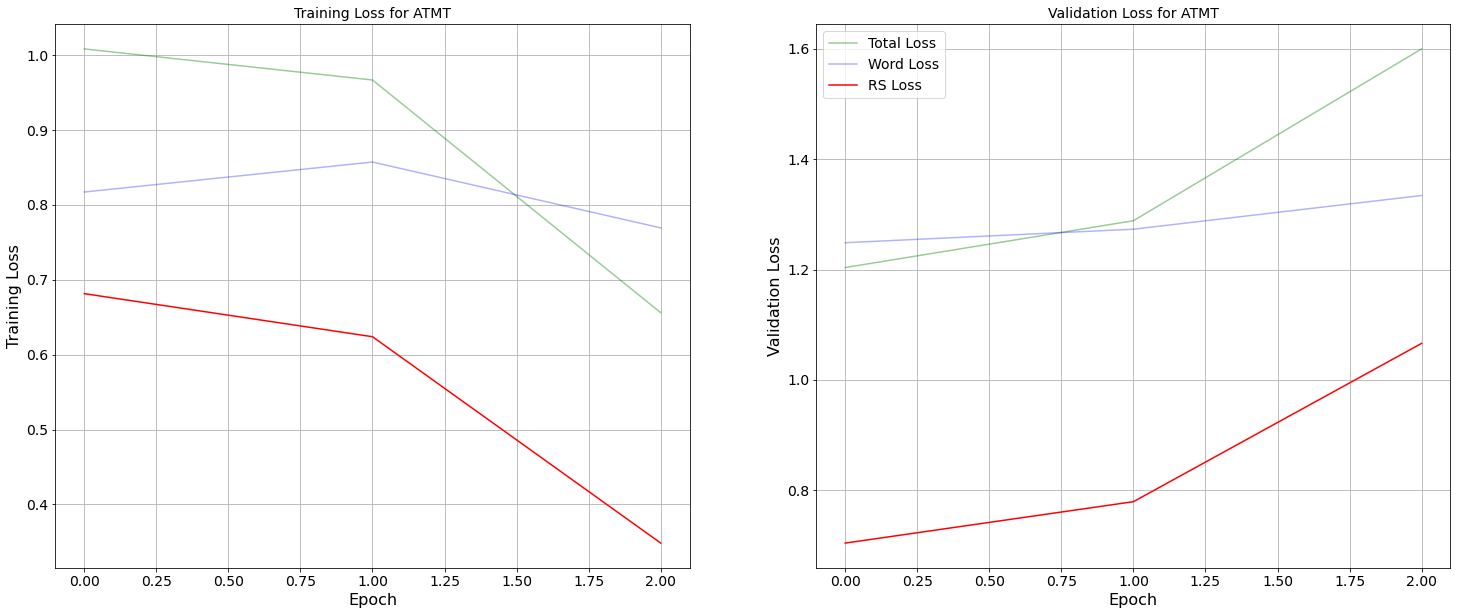

In [33]:
plot_epoch_loss_multi(losses_train[0.001,3,16,0.1,0.4])

In [21]:
metrics_train,metrics_test, losses_train, model_dict =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.1],
                                                            epochs=[1],
                                                            batch_sizes=[16],
                                                            dropouts=[0.1,0.3,0.5],
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Train Columns :
 Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Test Columns :
 Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Val Columns :
 Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Number of param combinations : 3
Running model for ----
 lr : 0.001
 epoch : 1
 batch_size : 16
 dropout : 0.1

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title'

In [22]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 2, 16, 0.1, 0.1)",overall,class_scores,0.188088,0.454545,0.118577,0.535842,0.500272
1,"(0.001, 2, 16, 0.1, 0.1)",overall,word_scores,0.000000,0.000000,0.000000,0.964158,0.000000
2,"(0.001, 2, 16, 0.1, 0.1)",cluster1,class_scores,0.208333,0.600000,0.126050,0.591398,0.531775
3,"(0.001, 2, 16, 0.1, 0.1)",cluster1,word_scores,0.000000,0.000000,0.000000,0.964158,0.000000
4,"(0.001, 2, 16, 0.1, 0.1)",cluster2,class_scores,0.171429,0.365854,0.111940,0.480287,0.466315
5,"(0.001, 2, 16, 0.1, 0.1)",cluster2,word_scores,0.000000,0.000000,0.000000,0.964158,0.000000
6,"(0.001, 2, 16, 0.3, 0.1)",overall,class_scores,0.232836,0.475610,0.154150,0.539427,0.506583
7,"(0.001, 2, 16, 0.3, 0.1)",overall,word_scores,0.000000,0.000000,0.000000,0.940860,0.000000
8,"(0.001, 2, 16, 0.3, 0.1)",cluster1,class_scores,0.307692,0.520000,0.218487,0.580645,0.534244
9,"(0.001, 2, 16, 0.3, 0.1)",cluster1,word_scores,0.000000,0.000000,0.000000,0.949821,0.000000


In [23]:
metrics_train,metrics_test, losses_train, model_dict =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.000001],
                                                            word_pred_loss_weights=[0.8],
                                                            epochs=[5],
                                                            batch_sizes=[16],
                                                            dropouts=[0.1,0.3,0.5],
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Train Columns :
 Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Test Columns :
 Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Val Columns :
 Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Number of param combinations : 3
Running model for ----
 lr : 1e-06
 epoch : 5
 batch_size : 16
 dropout : 0.1

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title'

In [24]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(1e-06, 5, 16, 0.1, 0.8)",overall,class_scores,0.607562,0.453307,0.920949,0.460573,0.499819
1,"(1e-06, 5, 16, 0.1, 0.8)",overall,word_scores,0.000000,0.000000,0.000000,1.000000,0.000000
2,"(1e-06, 5, 16, 0.1, 0.8)",cluster1,class_scores,0.597884,0.436293,0.949580,0.455197,0.518540
3,"(1e-06, 5, 16, 0.1, 0.8)",cluster1,word_scores,0.000000,0.000000,0.000000,1.000000,0.000000
4,"(1e-06, 5, 16, 0.1, 0.8)",cluster2,class_scores,0.616967,0.470588,0.895522,0.465950,0.482244
5,"(1e-06, 5, 16, 0.1, 0.8)",cluster2,word_scores,0.000000,0.000000,0.000000,1.000000,0.000000
6,"(1e-06, 6, 16, 0.3, 0.8)",overall,class_scores,0.000000,0.000000,0.000000,0.546595,0.500000
7,"(1e-06, 6, 16, 0.3, 0.8)",overall,word_scores,0.000000,0.000000,0.000000,1.000000,0.000000
8,"(1e-06, 6, 16, 0.3, 0.8)",cluster1,class_scores,0.000000,0.000000,0.000000,0.573477,0.500000
9,"(1e-06, 6, 16, 0.3, 0.8)",cluster1,word_scores,0.000000,0.000000,0.000000,1.000000,0.000000


In [20]:
metrics_train,metrics_test, losses_train, model_dict =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[1.0],
                                                            epochs=[5],
                                                            batch_sizes=[8],
                                                            dropouts=[0.1],
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Train Columns :
 Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Test Columns :
 Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Val Columns :
 Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Number of param combinations : 1
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title',

In [21]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 3, 8, 0.1, 1.0)",overall,class_scores,0.441113,0.481308,0.407115,0.532258,0.521590
1,"(0.001, 3, 8, 0.1, 1.0)",overall,word_scores,0.000000,0.000000,0.000000,0.623656,0.000000
2,"(0.001, 3, 8, 0.1, 1.0)",cluster1,class_scores,0.436364,0.475248,0.403361,0.555556,0.536056
3,"(0.001, 3, 8, 0.1, 1.0)",cluster1,word_scores,0.000000,0.000000,0.000000,0.569892,0.000000
4,"(0.001, 3, 8, 0.1, 1.0)",cluster2,class_scores,0.445344,0.486726,0.410448,0.508961,0.505224
5,"(0.001, 3, 8, 0.1, 1.0)",cluster2,word_scores,0.000000,0.000000,0.000000,0.677419,0.000000


# Debugging Attention Model

In [22]:
metrics_train,metrics_test_single, losses_train, model_dict =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=[5],
                                                            batch_sizes=[2],
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 10)
Original Test Shape : (1189, 10)
Data Sizes before addition of context words and context labels :
Train : (1103, 11)
Val : (224, 11)
Test : (558, 11)
Data Sizes after addition of context words and context labels :
Train : (1103, 11)
Val : (224, 11)
Test : (558, 11)
Train Columns :
 Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'processed_all', 'which_cluster'],
      dtype='object')
Test Columns :
 Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'processed_all', 'which_cluster'],
      dtype='object')
Val Columns :
 Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'processed_all', 'which_cluster'],
      dtype='obje

ValueError: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1000])) is deprecated. Please ensure they have the same size.